# Wine
This dataset contains tabular data on measured features of white wine.
The dataset contains 11 columns of features, a column of wine "quality" scores in [0,10], and a column to indicate 
wine "type", (such as grape variety). There are three types of wine coded: 1, 2, 3. The quality score could be the 
target of a regression model, and the wine type could be the target of a classification model.

The original data are described here:
	https://www.tensorflow.org/datasets/catalog/wine_quality

Also:

* Line that needs changing so that anyone can run this notebook, is the line importing the data. Simply change to respective location

* Model specifications and computations for epistemic and aleatoric uncertainty follow code from [this notebook](https://colab.research.google.com/github/onefishy/am207_fall19_projects/blob/master/what_uncertainties/what_uncertainties_3/cheruvuria_136145_9127626_Final_Project_Submission.ipynb#scrollTo=Xro86iRBavG_) 

PLEASE SPECIFY THE FILEPATH WHERE THIS WORK IS SAVED BELOW

In [4]:
filepath = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection"

# Preparation

In [5]:
from __future__ import print_function

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
from matplotlib.pyplot import imshow
import tqdm
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
import tensorflow_probability as tfp
distributions = tfp.distributions
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, r2_score
from sklearn.metrics import accuracy_score, mean_squared_error, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from itertools import product
from tensorflow.keras.regularizers import l2

Defining functions to call original or feature-normalised data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def get_wine_data(filepath=filepath):
    # wine
    df_wine = pd.read_csv(filepath+'/data/wine.csv')
    y_wine_type = df_wine["type"]
    y_wine_quality = df_wine["quality"]
    X_wine = df_wine.iloc[:, :-2]

    random_state = 10

    (X_wine_train_full, X_wine_test, 
    y_wine_train_full_type, y_wine_test_type,
    y_wine_train_full_quality, y_wine_test_quality) = train_test_split(X_wine, 
                                                                        y_wine_type,
                                                                        y_wine_quality, 
                                                                        test_size=0.2,
                                                                        random_state=random_state)

    (X_wine_train, X_wine_val, 
    y_wine_train_type, y_wine_val_type,
    y_wine_train_quality, y_wine_val_quality) = train_test_split(X_wine_train_full, 
                                                                y_wine_train_full_type,
                                                                y_wine_train_full_quality, 
                                                                test_size=0.25,
                                                                random_state=random_state)
                                                         

    return (df_wine, y_wine_type, y_wine_quality, X_wine,
            X_wine_test, y_wine_test_type, y_wine_test_quality,
            X_wine_train, y_wine_train_type, y_wine_train_quality,
            X_wine_val, y_wine_val_type, y_wine_val_quality)         

# normalise features
def get_sc_wine_data():
    (df_wine, y_wine_type, y_wine_quality, X_wine,
            X_wine_test, y_wine_test_type, y_wine_test_quality,
            X_wine_train, y_wine_train_type, y_wine_train_quality,
            X_wine_val, y_wine_val_type, y_wine_val_quality) = get_wine_data()

    sc_wine = StandardScaler()
    sc_wine_fit = sc_wine.fit(X_wine_train.values)
    sc_wine_transform = sc_wine_fit.transform(X_wine_train.values)
    sc_wine_transform_val = sc_wine_fit.transform(X_wine_val.values)
    sc_wine_transform_test = sc_wine_fit.transform(X_wine_test.values)

    X_wine_train = pd.DataFrame(sc_wine_transform, 
                                index=X_wine_train.index, 
                                columns=X_wine_train.columns)
    X_wine_val = pd.DataFrame(sc_wine_transform_val, 
                            index=X_wine_val.index, 
                            columns=X_wine_val.columns)
    X_wine_test = pd.DataFrame(sc_wine_transform_test,
                            index=X_wine_test.index, 
                            columns=X_wine_test.columns)   

    return (df_wine, y_wine_type, y_wine_quality, X_wine,
            X_wine_test, y_wine_test_type, y_wine_test_quality,
            X_wine_train, y_wine_train_type, y_wine_train_quality,
            X_wine_val, y_wine_val_type, y_wine_val_quality)   

# Data exploration

In [7]:
(df_wine, y_wine_type, y_wine_quality, X_wine,
            X_wine_test, y_wine_test_type, y_wine_test_quality,
            X_wine_train, y_wine_train_type, y_wine_train_quality,
            X_wine_val, y_wine_val_type, y_wine_val_quality)   = get_wine_data()
        

In [8]:
df_wine.isnull().sum().sum() # no missing value

0

In [9]:
df_wine.describe()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909,1.964475
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639,0.836162
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000,1.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000,1.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000,2.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000,3.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000,3.000000


## Balanced type classes

[1802, 1468, 1628]
[0, 0, 20, 163, 1457, 2198, 880, 175, 5]


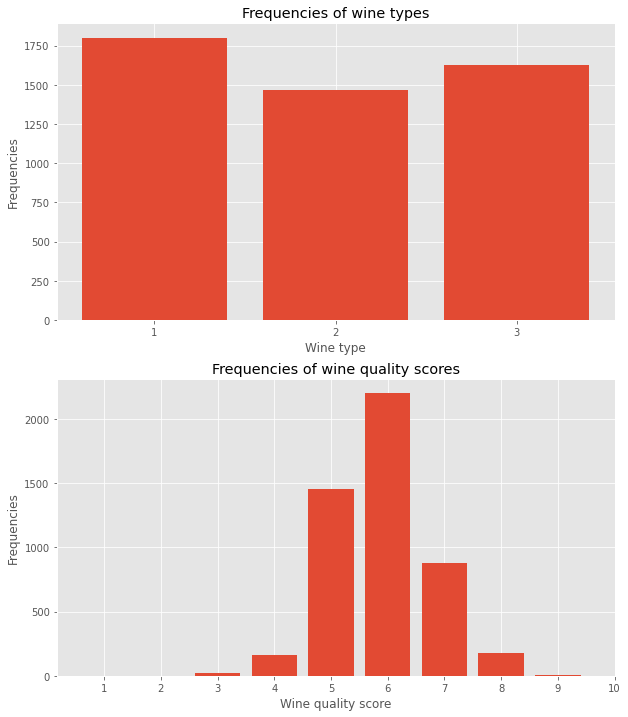

<Figure size 432x288 with 0 Axes>

there are 20 samples of wine with score 3

and there are 5 samples of wine with score 9

mean of wine quality = 5.88

std of wine quality = 0.89


In [10]:
num_type = []
for i in range(0, max(y_wine_type), 1):
    num_type.append(sum(y_wine_type==i+1))
print(num_type)

num_quality = []
for i in range(0, max(y_wine_quality), 1):
    num_quality.append(sum(y_wine_quality==i+1))
print(num_quality)

fig, axs = plt.subplots(2,1, figsize=(10,12))
fig = plt.figure()
axs[0].bar(range(1, max(y_wine_type)+1, 1), num_type)
axs[0].set_title('Frequencies of wine types')
axs[0].set_ylabel('Frequencies')
axs[0].set_xlabel('Wine type')
axs[0].set_xticks(np.arange(1,4,1))

axs[1].bar(range(1, max(y_wine_quality)+1, 1), num_quality)
axs[1].set_title('Frequencies of wine quality scores')
axs[1].set_ylabel('Frequencies')
axs[1].set_xlabel('Wine quality score')
axs[1].set_xticks(np.arange(1,11,1))

plt.show()

print("there are", sum(y_wine_quality==3), "samples of wine with score 3\n")
print("and there are", sum(y_wine_quality==9), "samples of wine with score 9\n")

print(f"mean of wine quality = {np.mean(y_wine_quality):.2f}")
print(f"\nstd of wine quality = {np.std(y_wine_quality):.2f}")

## Correlation plots
code from [here](https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
)

In [11]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [12]:
wine_corr = df_wine.corr().abs()
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_wine, 20))

Top Absolute Correlations
residual.sugar        density                 0.838966
density               alcohol                 0.780138
                      type                    0.704534
residual.sugar        type                    0.647108
free.sulfur.dioxide   total.sulfur.dioxide    0.615501
alcohol               type                    0.576035
total.sulfur.dioxide  density                 0.529881
                      type                    0.502521
residual.sugar        alcohol                 0.450631
total.sulfur.dioxide  alcohol                 0.448892
alcohol               quality                 0.435575
fixed.acidity         pH                      0.425858
pH                    type                    0.409653
residual.sugar        total.sulfur.dioxide    0.401439
free.sulfur.dioxide   type                    0.371048
chlorides             alcohol                 0.360189
fixed.acidity         type                    0.353686
density               quality          

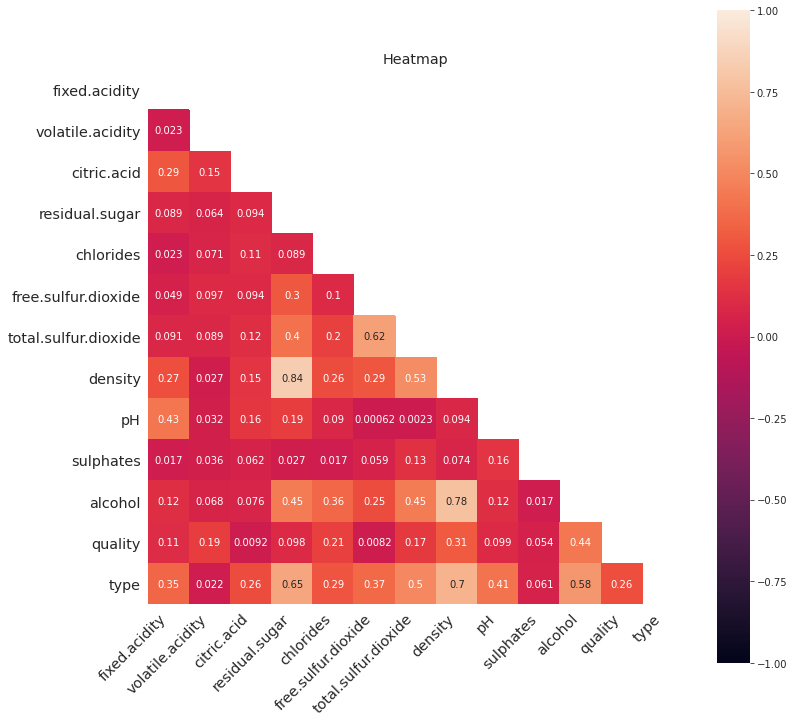

In [13]:
mask = np.zeros_like(wine_corr)
mask[np.triu_indices_from(mask)] = True # comment this out to get full correlation matrix
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax.set_title("Heatmap")
    ax = sns.heatmap(wine_corr, mask=mask, annot=True, vmax=1, vmin=-1, square=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',
                      fontweight='light', fontsize='x-large')
    ax.set_yticklabels(ax.get_xticklabels(), horizontalalignment='right',
                      fontweight='light', fontsize='x-large')
plt.show()

## Feature distributions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

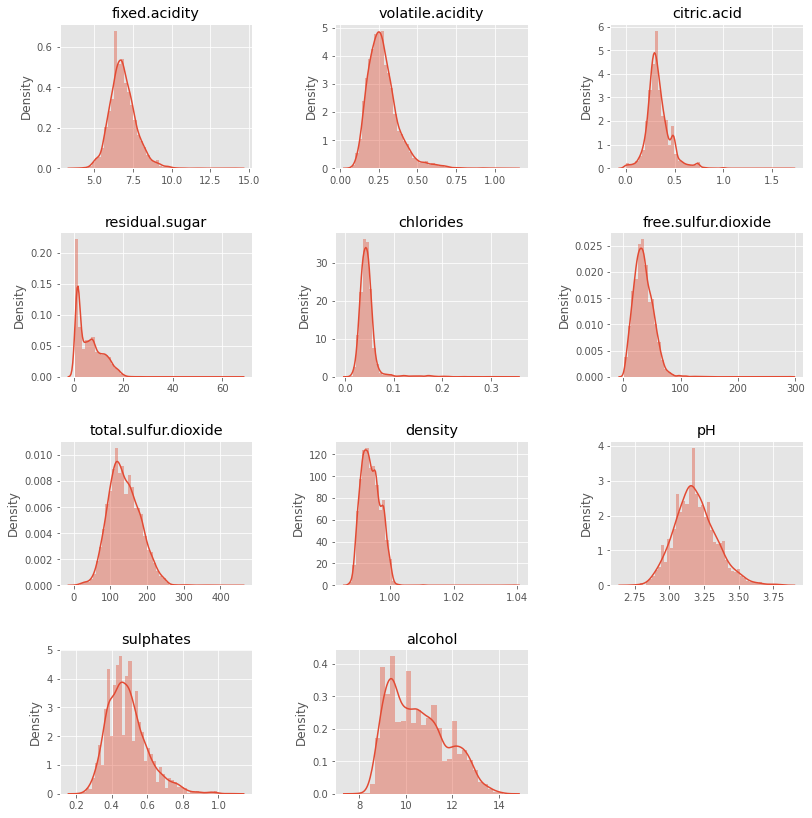

In [14]:
fig, axs = plt.subplots(4,3,figsize=(12,12))

for ax, var in zip(axs.reshape(-1), df_wine.iloc[:, :-2]): 
    sns.distplot(df_wine[var], ax=ax)
    ax.set_title(var)
    ax.set_xlabel('')

fig.tight_layout(pad=3.0)
axs[-1, -1].axis('off')    
plt.show()

## Feature distribution by wine type

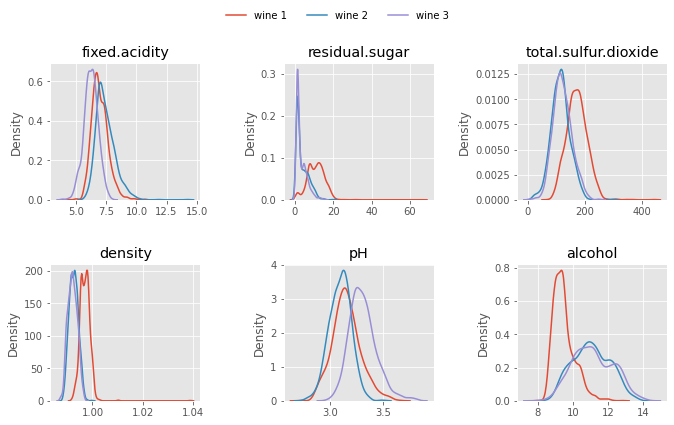

In [15]:
label_type = [1,2,3]

# fig, axs = plt.subplots(4,3,figsize=(12,12))
fig, axs = plt.subplots(2,3,figsize=(10,6))
# picking out the ones where distributions differ
for ax, var in zip(axs.reshape(-1), df_wine.iloc[:, [0,3,6,7,8,10]]): # df_wine.iloc[:, :-2]): 
    for wine in label_type:
        mask = df_wine["type"]==wine
        plot_data = df_wine.loc[mask,]
        sns.kdeplot(plot_data[var], ax=ax, label="wine "+ str(wine))
        ax.set_title(var)
        ax.set_xlabel('')
        #ax.set_ylabel('Density')

axs[0,0].set_ylabel('Density')
axs[1,0].set_ylabel('Density')
#axs[2,0].set_ylabel('Density')
#axs[3,0].set_ylabel('Density')
fig.tight_layout(pad=3.0)
#axs[-1, -1].axis('off')   

# axs[0,0].legend(ncol=6, bbox_to_anchor=(0.5, 0.93), bbox_transform=fig.transFigure, loc='center', frameon=False)
axs[0,0].legend(bbox_to_anchor=(0.5, 1), loc='center', bbox_transform=fig.transFigure,
               frameon=False, ncol=3)

[ax.legend().remove() for ax in axs.reshape(-1)[1:]];

plt.show()


## PCA for dimensionality reduction

The actual PCA plots are further down in this notebook in [this section](#cell-id). Below, is a scatter function (based on code from DME labs) to visualise PCA embeddings. 

In [16]:
def scatter_2d_label_LOF(X_2d, y, X_scores, uncertainty, descr,
                         ax=None, s=2, alpha=0.5, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    X_scores : scores from LOF fit_predict
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    
    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(palette='bright', n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                   color=color, label=target, s=s, alpha=alpha, lw=lw)
        
        radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                     edgecolors=color, label='Outlier scores', 
                     s=1000 * radius[y == target], 
                     alpha=alpha, lw=lw, facecolors='none')
        
    ax.scatter(X_2d[uncertainty, 0], X_2d[uncertainty, 1], color="black", s=10,
               label=descr)
    
    ax.set_xlabel("Principle Component 1")
    ax.set_ylabel("Principle Component 2")
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], 
              scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax


In [17]:
def scatter_2d_label_LOF_with_highest(X_2d, y, X_scores, uncertainty, 
                                      highest_uncertainty, descr, 
                                      descr_2, ax=None, s=2, alpha=0.5, lw=2):
    """
    2nd version of scatter plot to highlight sample with highest uncertainty
    """
    
    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(palette='bright', n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                   color=color, label="Wine Type " + str(target), 
                   s=s, alpha=alpha, lw=lw)
        
        radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                     edgecolors=color, label='Outlier scores', 
                     s=1000 * radius[y == target], 
                     alpha=alpha, lw=lw, facecolors='none')
        
    ax.scatter(X_2d[uncertainty, 0], X_2d[uncertainty, 1], color="black", s=30,
               label=descr)
    ax.scatter(X_2d[highest_uncertainty, 0], X_2d[highest_uncertainty, 1], 
               color="red", s=200, label=descr_2)
    ax.set_xlabel("Principle Component 1")
    ax.set_ylabel("Principle Component 2")
    # add legend
    #ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], 
    #          scatterpoints=1, frameon=False); # Add a legend outside the plot at specified point
    ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', #bbox_transform=fig.transFigure,
               frameon=False, ncol=4, prop={"size":18},handletextpad=0.01)

    
    return ax


before continuing with the next part, we call the data with standardised features. This is particularly important for the PCA results. Furthermore, the labels are transformed to one-hot encodings

In [18]:
(df_wine, y_wine_type, y_wine_quality, X_wine,
    X_wine_test, y_wine_test_type, y_wine_test_quality,
    X_wine_train, y_wine_train_type, y_wine_train_quality,
    X_wine_val, y_wine_val_type, y_wine_val_quality) = get_sc_wine_data()

In [19]:
y_wine_type_original = y_wine_type
y_wine_type = tf.keras.utils.to_categorical(y_wine_type-1, num_classes=3)

y_wine_test_type_original = y_wine_test_type
y_wine_test_type = tf.keras.utils.to_categorical(y_wine_test_type-1, num_classes=3)

y_wine_train_type_original = y_wine_train_type
y_wine_train_type = tf.keras.utils.to_categorical(y_wine_train_type-1, num_classes=3)

y_wine_val_type_original = y_wine_val_type
y_wine_val_type = tf.keras.utils.to_categorical(y_wine_val_type-1, num_classes=3)

# Save function
to save trained models (not necessary for this notebook)

In [20]:
def save_model(model, batch_size, n_epochs, descr, n_hidden, dropout=None):
    fpf = '/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models'
    fp0 = "/model_" + descr
    fp1 = "_batchsize" + str(batch_size)
    fp2 = "_nepoch" + str(n_epochs)
    if dropout == None:
        fp3 = ""
    else:
        fp3 = '_dropout' + str(dropout*10)

    fp4 = "_nhidden"
    for i in n_hidden:
      fp4 = fp4 + "_" + str(i)
    fp5 = ".h5"

    fp_full = fpf + fp0 + fp1 + fp2 + fp3 + fp4 + fp5

    model.save(fp_full)

# Loss function

this includes all necessary loss fucnctions. ```bayesian_categorical_crossentropy``` is the loss used to model aleatoric uncertainty discussed in the report

In [21]:
def softmax(pred):
  return K.exp(pred - K.log(K.sum(K.exp(pred))))  # numerically stable softmax
  
def softmax_np(pred):
  return np.exp(pred - np.log(np.sum(np.exp(pred), axis=1)).reshape(pred.shape[0],1))  

def gaussian_softmax(ypred, dist, num_classes):
  def map_fn(i):
    std_samples = K.transpose(dist.sample(num_classes))
    distorted_loss = softmax(ypred + std_samples)
    return distorted_loss
  return map_fn

# aleatoric loss function
def bayesian_categorical_crossentropy(T, num_classes):
  def bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
    std = K.exp(0.5*ypred_var[:, num_classes:])[0] # add this 
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')
    
    variance_loss = K.categorical_crossentropy(ytrue, K.mean(monte_carlo_results, axis=0))
    
    return variance_loss 
  
  return bayesian_categorical_crossentropy_internal

def simple_bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
  #A slight modification to the original fuction for the simple example
    std = K.exp(0.5*ypred_var[:, num_classes:])[0] # here too
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')
    
    predictions = K.categorical_crossentropy(ytrue, y_pred)
    
    return predictions 



# Loss and accuracy plot function

In [22]:
def loss_accuracy_plot(fit_history):
  # Plot training & validation accuracy values
  plt.plot(fit_history.history['accuracy'])
  plt.plot(fit_history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(fit_history.history['loss'])
  plt.plot(fit_history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

# Model specification

The model specification is such that ```get_model``` corresponds to 

* the baseline, if ```dropout_prob=0.0``` and ```include_logvar=False```

* the model for epistemic uncertainty, if ```dropout_prob!=0.0``` and ```include_logvar=False```

* the model for aleatoric uncertainty, if ```dropout_prob=0.0``` and ```include_logvar=True```

* the model for aleatoric & epistemic uncertainty, if ```dropout_prob!=0.0``` and ```include_logvar=True```

In [23]:
def get_model(act="relu", n_hidden=[64, 64], dropout_prob=0.0, 
              loss=keras.losses.categorical_crossentropy, include_logvar=False,
              optimizer=keras.optimizers.Adadelta()):
    N = 11 # only dealing with same inputs
    reg = (1 - dropout_prob) / (2. * N) if dropout_prob > 0 else 0

    inputs = Input(input_shape)
    inter = Dense(n_hidden[0], activation=act,
                  kernel_regularizer=l2(reg))(inputs)

    for i in range(len(n_hidden) - 1):
        inter = Dropout(dropout_prob)(inter, training=True)
        inter = Dense(n_hidden[i+1], activation=act,
                      kernel_regularizer=l2(reg))(inter)

    inter = Dropout(dropout_prob)(inter, training=True)
    inter = Flatten()(inter)

    if include_logvar: # for inclusion of aleatoric variance
        outputs = Dense(num_classes+1, activation=None, 
                        kernel_regularizer=l2(reg))(inter) 
    else:
        outputs = Dense(num_classes, activation='softmax', 
                        kernel_regularizer=l2(reg))(inter) 
    
    model = Model(inputs=inputs, outputs=outputs)

    metrics = ['accuracy']
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics,
                  run_eagerly=True)
    return model

# Baseline Model

Different values for the parameters

* batch_size

* learning_rate

* n_hidden

were tried (see Appendix of notebook for hyperparameter tuning). The specifications below yielded one of the best performance on the validation set

In [24]:
# fixed params
num_classes = 3
input_shape = (11)

# hyperparameters
batch_size = 128
epochs = 20
dropout_p = 0.0
n_hidden = [64, 64] 
learning_rate = 0.001

In [25]:
"""model_orig = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_orig.summary()"""

'model_orig = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,\n                       optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))\nmodel_orig.summary()'

In [26]:
"""plot_model(model_orig)"""

'plot_model(model_orig)'

## Model fitting

We have already decided which hyperparameters to use on the validation data (see appendix). From now on, we will be using the test set for any further evaluations as well as computations of uncertainties.

In [27]:
"""history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_test, y_wine_test_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)"""

'history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, \n                       validation_data=(X_wine_test, y_wine_test_type), \n                       batch_size=batch_size, epochs=epochs, verbose=1)'

In [28]:
"""save_model(model=model_orig, batch_size=batch_size, n_hidden=n_hidden,
           n_epochs=epochs, descr="orig_wine", dropout=None)"""

'save_model(model=model_orig, batch_size=batch_size, n_hidden=n_hidden,\n           n_epochs=epochs, descr="orig_wine", dropout=None)'

In [29]:
model_orig = orig_mnist_model_cnn = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models/model_orig_wine_batchsize128_nepoch20_nhidden_64_64.h5")

In [30]:
"""loss_orig_eval, accuracy_orig_eval = model_orig.evaluate(X_wine_test, y_wine_test_type, verbose=0)
print(f"Eval loss = {loss_orig_eval}, Eval accuracy = {accuracy_orig_eval}")"""

'loss_orig_eval, accuracy_orig_eval = model_orig.evaluate(X_wine_test, y_wine_test_type, verbose=0)\nprint(f"Eval loss = {loss_orig_eval}, Eval accuracy = {accuracy_orig_eval}")'

# EPISTEMIC

In [31]:
# fixed params
num_classes = 3
input_shape = (11)

# try different options for these
batch_size = 128
epochs = 20
dropout_p = 0.2
n_hidden = [64, 64] 
learning_rate = 0.001

## Model fitting

In [32]:
"""mc_model = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
mc_model.summary()"""

'mc_model = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,\n                       optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))\nmc_model.summary()'

In [33]:
"""history_mc_model = mc_model.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_test, y_wine_test_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)"""

'history_mc_model = mc_model.fit(X_wine_train, y_wine_train_type, \n                       validation_data=(X_wine_test, y_wine_test_type), \n                       batch_size=batch_size, epochs=epochs, verbose=1)'

In [34]:
"""save_model(model=mc_model, batch_size=batch_size, n_hidden=n_hidden,
           n_epochs=epochs, descr="mc_model_wine", dropout=dropout_p)"""

'save_model(model=mc_model, batch_size=batch_size, n_hidden=n_hidden,\n           n_epochs=epochs, descr="mc_model_wine", dropout=dropout_p)'

In [35]:
mc_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models/model_mc_model_wine_batchsize128_nepoch20_dropout2.0_nhidden_64_64.h5")

In [36]:
"""loss_mc_model_eval, mc_model_accuracy_eval = mc_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)
print(f"Eval loss = {loss_mc_model_eval}, Eval accuracy = {mc_model_accuracy_eval}")"""

'loss_mc_model_eval, mc_model_accuracy_eval = mc_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)\nprint(f"Eval loss = {loss_mc_model_eval}, Eval accuracy = {mc_model_accuracy_eval}")'

## accuracy plots

In [37]:
"""loss_accuracy_plot(history_mc_model)"""

'loss_accuracy_plot(history_mc_model)'

## Functions for epistemic uncertainties

In [38]:
# making 100 predictions for each sample of val set for each class
import tqdm
def make_predictions(model, n_pred=100, batch_size=100, val_data=X_wine_test):
  predictions = []
  for i in tqdm.tqdm(range(n_pred)):
      y_p = model.predict(val_data, batch_size=batch_size)
      predictions.append(y_p)
  return predictions

In [39]:
# calculate mean predictions, std, and epistemic uncertainty
def cal_epistemic(predictions):
  p = np.array(predictions)
  y_mean = p.mean(axis=0) # prediction mean of 100 predictions
  w = 1/np.sum(y_mean, axis=1).reshape(y_mean.shape[0],1)
  y_mean = (y_mean*w)
  y_std = p.std(axis=0)*w

  epi_1 = y_std.max(axis=1)
  epi_2 = y_std.mean(axis=1)
  epi_3 = -(p.mean(axis=0) * np.log(p.mean(axis=0))).sum(axis=1)
  return y_mean, y_std, [epi_1, epi_2, epi_3]

In [40]:
# calculate mean ensemble prediction and accuracy
def ensemble_pred(predictions, val_data=y_wine_test_type):
  ensemble_pred = np.array(predictions).mean(axis=0).argmax(axis=1) # max mean pred
  ensemble_acc = accuracy_score(val_data.argmax(axis=1), ensemble_pred)
  print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))
  return ensemble_pred, ensemble_acc

In [41]:
def show_epistemic(epi, prediction, highest=True, n_epi=20,
                   x_data=X_wine_test, y_data=y_wine_test_type_original):
  if highest == True:
    epi_idx = epi.argsort()[::-1]
  if highest == False:
    epi_idx = epi.argsort()

  plt.hist(y_data.iloc[epi_idx[:n_epi]])
  plt.show()
  for idx in epi_idx[:n_epi]:
    print("True label of the test sample {}: {}".format(idx, y_data.iloc[idx], axis=-1))
    print(f"Predicted label of test sample {idx}: {prediction[idx]+1}")
    print(f"Epistemic uncertainty: {epi[idx]:.4}")
    plt.show()

## Calculating epistemic uncertainties


In [42]:
"""mc_predictions = make_predictions(mc_model)
mc_ensemble_pred, mc_ensemble_acc = ensemble_pred(mc_predictions)
mc_y_mean, mc_y_std, mc_epistemic = cal_epistemic(mc_predictions)"""

'mc_predictions = make_predictions(mc_model)\nmc_ensemble_pred, mc_ensemble_acc = ensemble_pred(mc_predictions)\nmc_y_mean, mc_y_std, mc_epistemic = cal_epistemic(mc_predictions)'

In [43]:
"""from numpy import savetxt
fp = filepath + "/TEST_saved_uncertainties"
savetxt(fp + '/mc_epistemic_wine.csv', mc_epistemic, delimiter=',')
savetxt(fp + '/mc_y_mean_wine.csv', mc_y_mean, delimiter=',')
savetxt(fp + '/mc_ensemble_pred_wine.csv', mc_ensemble_pred, delimiter=',')"""

'from numpy import savetxt\nfp = filepath + "/TEST_saved_uncertainties"\nsavetxt(fp + \'/mc_epistemic_wine.csv\', mc_epistemic, delimiter=\',\')\nsavetxt(fp + \'/mc_y_mean_wine.csv\', mc_y_mean, delimiter=\',\')\nsavetxt(fp + \'/mc_ensemble_pred_wine.csv\', mc_ensemble_pred, delimiter=\',\')'

In [44]:
from numpy import loadtxt
fp = filepath + "/TEST_saved_uncertainties"
mc_epistemic = loadtxt(fp+'/mc_epistemic_wine.csv', delimiter=',')
mc_y_mean = loadtxt(fp+'/mc_y_mean_wine.csv', delimiter=',')
mc_ensemble_pred = loadtxt(fp+'/mc_ensemble_pred_wine.csv', delimiter=',')

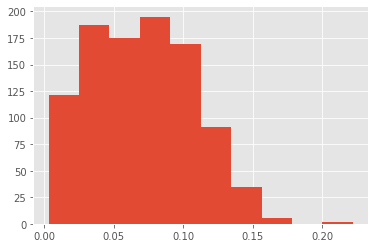

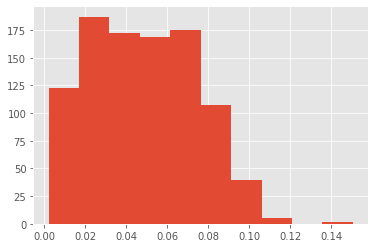

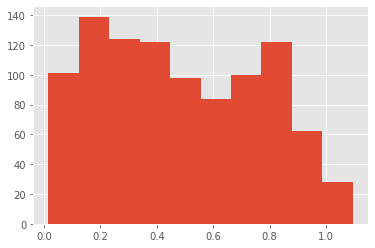

In [45]:
for i in [0,1,2]:
  plt.hist(mc_epistemic[i])
  plt.show()

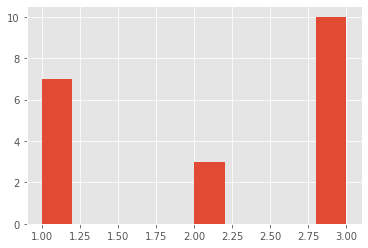

True label of the test sample 366: 1
Predicted label of test sample 366: 1.0
Epistemic uncertainty: 0.2223
True label of the test sample 679: 1
Predicted label of test sample 679: 1.0
Epistemic uncertainty: 0.2207
True label of the test sample 239: 1
Predicted label of test sample 239: 1.0
Epistemic uncertainty: 0.1704
True label of the test sample 504: 3
Predicted label of test sample 504: 3.0
Epistemic uncertainty: 0.1699
True label of the test sample 148: 3
Predicted label of test sample 148: 3.0
Epistemic uncertainty: 0.1696
True label of the test sample 79: 1
Predicted label of test sample 79: 1.0
Epistemic uncertainty: 0.1652
True label of the test sample 42: 3
Predicted label of test sample 42: 3.0
Epistemic uncertainty: 0.164
True label of the test sample 787: 3
Predicted label of test sample 787: 3.0
Epistemic uncertainty: 0.1532
True label of the test sample 166: 1
Predicted label of test sample 166: 1.0
Epistemic uncertainty: 0.1506
True label of the test sample 749: 3
Predi

In [46]:
show_epistemic(mc_epistemic[0], mc_ensemble_pred)

<a name="cell-id"></a>
## Plotting Wine PCA with epistemic uncertainties and LOF anomalies


### PCA

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Initialise a PCA instance
X_pca_wine = pca.fit_transform(X_wine_test)

In [48]:
X_pca_wine

array([[-0.65974147, -1.7082156 ],
       [ 1.830381  ,  0.04103752],
       [ 6.93717581,  0.74225613],
       ...,
       [-1.98391262,  1.56761577],
       [ 1.74566321,  0.53319437],
       [-0.69925812, -1.77969585]])

### LOF

we now determine outliers with LOF approach and compare it to the results from BNN

In [49]:
from sklearn.neighbors import LocalOutlierFactor
clf_wine = LocalOutlierFactor(n_neighbors=10)
result_wine = clf_wine.fit_predict(X_wine_test)

# outliers predicted with LOF
outlier_index_wine = np.where(result_wine == -1)
X_scores_wine = clf_wine.negative_outlier_factor_
print("number of outliers: ", len(outlier_index_wine[0]))
print("index of outliers:\n", outlier_index_wine)

number of outliers:  26
index of outliers:
 (array([ 82,  93, 109, 154, 205, 216, 239, 255, 282, 355, 398, 426, 459,
       479, 501, 523, 540, 643, 646, 679, 763, 853, 872, 885, 897, 919]),)


### Plot PCA, LOF

visualize these results in PCA plots

In [50]:
epi_idx = mc_epistemic[2].argsort()[::-1]
# want to plot n samples with highest epistemic uncertainty
n = 200
highest_epi = epi_idx[:n]
selected_uncertainty = epi_idx[0]

In [51]:
outlier_index_wine

(array([ 82,  93, 109, 154, 205, 216, 239, 255, 282, 355, 398, 426, 459,
        479, 501, 523, 540, 643, 646, 679, 763, 853, 872, 885, 897, 919]),)

In [52]:
# only a few overlaps of the results
np.intersect1d(outlier_index_wine, highest_epi)

array([109, 501, 897])

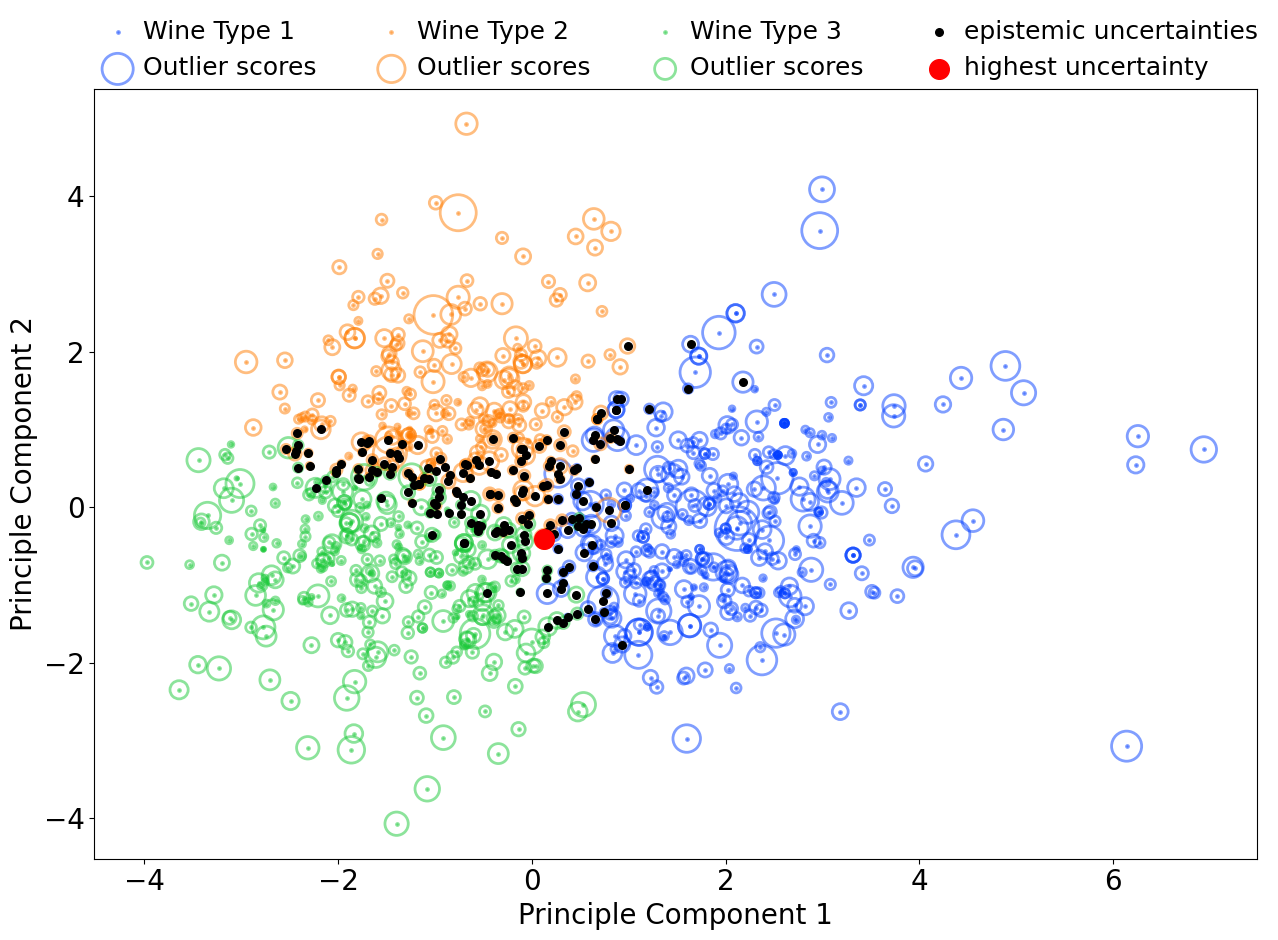

In [53]:
plt.style.use('default')
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF_with_highest(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine, highest_epi, selected_uncertainty, 
                     descr="epistemic uncertainties", descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
plt.show()

## Check if epistemic uncertainty decreases with increasing sample size

As epistemic uncertainty can be explained away with more data, expecting a decrease of epistemic uncertainty for increasing training sizes

In [54]:
"""sample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]
# sample_sizes = [0.5, 0.75]

def check_epistemic(X_train, y_train, X_test, y_test, sample_sizes, model,
                    random_state=10):
  # for loop to calculate epistemic uncertainties for different sample sizes
  epi_list = []
  epi_mean_list = []

  for sample_size in sample_sizes:
      # create differnt training sizes
      (X_train_helper, _, 
      y_train_helper, _) = train_test_split(X_train, 
                                            y_train,
                                            test_size=1-sample_size,
                                            random_state=random_state)

      # fit the model
      mc_model_helper = get_model(act="relu", dropout_prob=0.2, n_hidden=[64,64],
                            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
      history_mc_model_helper = mc_model_helper.fit(X_train_helper, y_train_helper, 
                          validation_data=(X_test, y_test), 
                          batch_size=128, epochs=20, verbose=0)
      
      # calculate epistemic uncertainties
      mc_predictions_helper = make_predictions(mc_model_helper)
      mc_y_mean_helper, mc_y_std_helper, mc_epistemic_helper = cal_epistemic(mc_predictions_helper)
      epi_list.append(mc_epistemic_helper)
      epi_mean_list.append(np.mean(mc_epistemic_helper, axis=1))

  # repeat for the original (full) model as well
  mc_predictions_helper = make_predictions(model)
  mc_y_mean_helper, mc_y_std_helper, mc_epistemic_helper = cal_epistemic(mc_predictions_helper)
  epi_list.append(mc_epistemic_helper)
  epi_mean_list.append(np.mean(mc_epistemic_helper, axis=1))

  return epi_list, epi_mean_list"""

'sample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]\n# sample_sizes = [0.5, 0.75]\n\ndef check_epistemic(X_train, y_train, X_test, y_test, sample_sizes, model,\n                    random_state=10):\n  # for loop to calculate epistemic uncertainties for different sample sizes\n  epi_list = []\n  epi_mean_list = []\n\n  for sample_size in sample_sizes:\n      # create differnt training sizes\n      (X_train_helper, _, \n      y_train_helper, _) = train_test_split(X_train, \n                                            y_train,\n                                            test_size=1-sample_size,\n                                            random_state=random_state)\n\n      # fit the model\n      mc_model_helper = get_model(act="relu", dropout_prob=0.2, n_hidden=[64,64],\n                            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))\n      history_mc_model_helper = mc_model_helper.fit(X_train_helper, y_train_helper, \n                          validation_data=(X_test, y_tes

In [55]:
"""import random
for _ in range(10): 
  random_state = random.randint(1,1e4)
  print(f"random state is {random_state}")
  epi_list, epi_mean_list = check_epistemic(X_train=X_wine_train, y_train=y_wine_train_type, 
                                         X_test=X_wine_test, y_test=y_wine_test_type, 
                                         sample_sizes=sample_sizes, 
                                         model=mc_model, random_state=random_state)

  x_samples = [i * X_wine_train.shape[0] for i in sample_sizes] 
  x_samples.append(X_wine_train.shape[0])
  for i in range(len(epi_mean_list[0])):
    y_epi = [epi[i] for epi in epi_mean_list]
    plt.plot(x_samples, y_epi)
  plt.show()"""

'import random\nfor _ in range(10): \n  random_state = random.randint(1,1e4)\n  print(f"random state is {random_state}")\n  epi_list, epi_mean_list = check_epistemic(X_train=X_wine_train, y_train=y_wine_train_type, \n                                         X_test=X_wine_test, y_test=y_wine_test_type, \n                                         sample_sizes=sample_sizes, \n                                         model=mc_model, random_state=random_state)\n\n  x_samples = [i * X_wine_train.shape[0] for i in sample_sizes] \n  x_samples.append(X_wine_train.shape[0])\n  for i in range(len(epi_mean_list[0])):\n    y_epi = [epi[i] for epi in epi_mean_list]\n    plt.plot(x_samples, y_epi)\n  plt.show()'

Here, the epistemic uncertainty decreases with increasing training set size, the results of this analysis are found further below in "Effect of increase in training size on uncertainty"

# ALEATORIC

In [56]:
num_classes=3
T = 30
# NEED LOSS FUNCTION BELOW! as discussed in report
loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

n_hidden = [64, 64] 
batch_size = 128
epochs = 20
input_shape = (11)

## Model fitting

In [57]:
"""alea_model = get_model(act="relu", dropout_prob=0.0, n_hidden=n_hidden,
                       include_logvar=True, loss=loss_fn,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
alea_model.summary()"""

'alea_model = get_model(act="relu", dropout_prob=0.0, n_hidden=n_hidden,\n                       include_logvar=True, loss=loss_fn,\n                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))\nalea_model.summary()'

In [58]:
"""history_alea_model = alea_model.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_test, y_wine_test_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)"""

'history_alea_model = alea_model.fit(X_wine_train, y_wine_train_type, \n                       validation_data=(X_wine_test, y_wine_test_type), \n                       batch_size=batch_size, epochs=epochs, verbose=1)'

In [59]:
"""save_model(model=alea_model, batch_size=batch_size, n_hidden=n_hidden,
           n_epochs=epochs, descr="alea_model_wine", dropout=None)"""

'save_model(model=alea_model, batch_size=batch_size, n_hidden=n_hidden,\n           n_epochs=epochs, descr="alea_model_wine", dropout=None)'

In [60]:
alea_model =  tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models/model_alea_model_wine_batchsize128_nepoch20_nhidden_64_64.h5",
                                          custom_objects={"bayesian_categorical_crossentropy_internal": bayesian_categorical_crossentropy})

In [61]:
"""loss_alea_model_eval, accuracy_alea_model_eval = alea_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)
print(f"Eval loss = {loss_alea_model_eval}, Eval accuracy = {accuracy_alea_model_eval}")"""

'loss_alea_model_eval, accuracy_alea_model_eval = alea_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)\nprint(f"Eval loss = {loss_alea_model_eval}, Eval accuracy = {accuracy_alea_model_eval}")'

## accuracy plots

In [62]:
"""loss_accuracy_plot(history_alea_model)"""

'loss_accuracy_plot(history_alea_model)'

## Functions for aleatoric uncertainties

In [63]:
# calculate predicted classes and aleatoric uncertainties
def cal_aleatoric(model, test_data=X_wine_test):
  output_alea = tf.convert_to_tensor(model.predict(test_data))
  # predicted_classes = np.argmax(output_alea[:,:3], axis=-1)
  predicted_classes = np.argmax(tf.keras.activations.softmax(output_alea[:,:3]).numpy(), 
                                axis=-1)
  sigmas = np.exp(output_alea[:,3])
  return predicted_classes, sigmas

# returns index of highest/lowest uncertainties and plots histogram of 
# which samples are in highest aleatoric uncertainties
def show_aleatoric(sigmas, prediction, highest=True, n_alea=20,
                   x_data=X_wine_test, y_data=y_wine_test_type_original):
    if highest == True:
      alea_idx = sigmas.argsort()[::-1]
    if highest == False:
      alea_idx = sigmas.argsort()
    plt.hist(y_data.iloc[alea_idx[:n_alea]])
    plt.show()
    return alea_idx

## Calculating aleatoric uncertainties

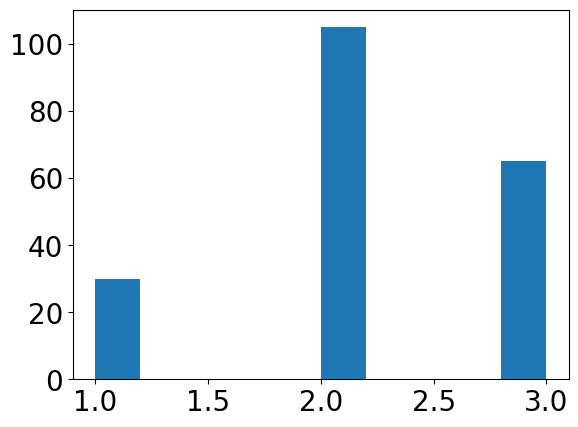

In [64]:
pred_class_alea, sigmas_alea = cal_aleatoric(alea_model)
alea_idx = show_aleatoric(sigmas_alea, pred_class_alea, n_alea=200)

In [65]:
fp = filepath + "/TEST_saved_uncertainties"
sigmas_alea = loadtxt(fp+'/alea_wine.csv', delimiter=',')
pred_class_alea = loadtxt(fp+'/pred_class_alea_wine.csv', delimiter=',')

In [66]:
"""fp = filepath + "/TEST_saved_uncertainties"
savetxt(fp + '/alea_wine.csv', sigmas_alea, delimiter=',')
savetxt(fp + '/pred_class_alea_wine.csv', pred_class_alea, delimiter=',')"""

'fp = filepath + "/TEST_saved_uncertainties"\nsavetxt(fp + \'/alea_wine.csv\', sigmas_alea, delimiter=\',\')\nsavetxt(fp + \'/pred_class_alea_wine.csv\', pred_class_alea, delimiter=\',\')'

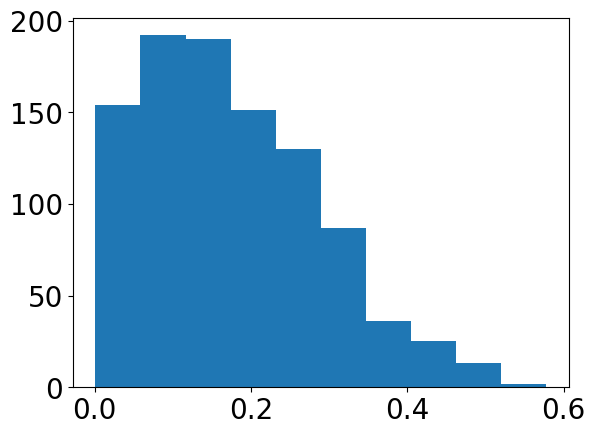

In [67]:
plt.hist(sigmas_alea)
plt.show()

## Plotting Wine PCA with aleatoric uncertainties and LOF anomalies


### Plot


In [68]:
n = 200
uncertainty_all = sigmas_alea.argsort()[::-1]
uncertainty = uncertainty_all[:n]
selected_uncertainty = uncertainty_all[0]

In [69]:
np.intersect1d(outlier_index_wine, uncertainty)

array([501, 897])

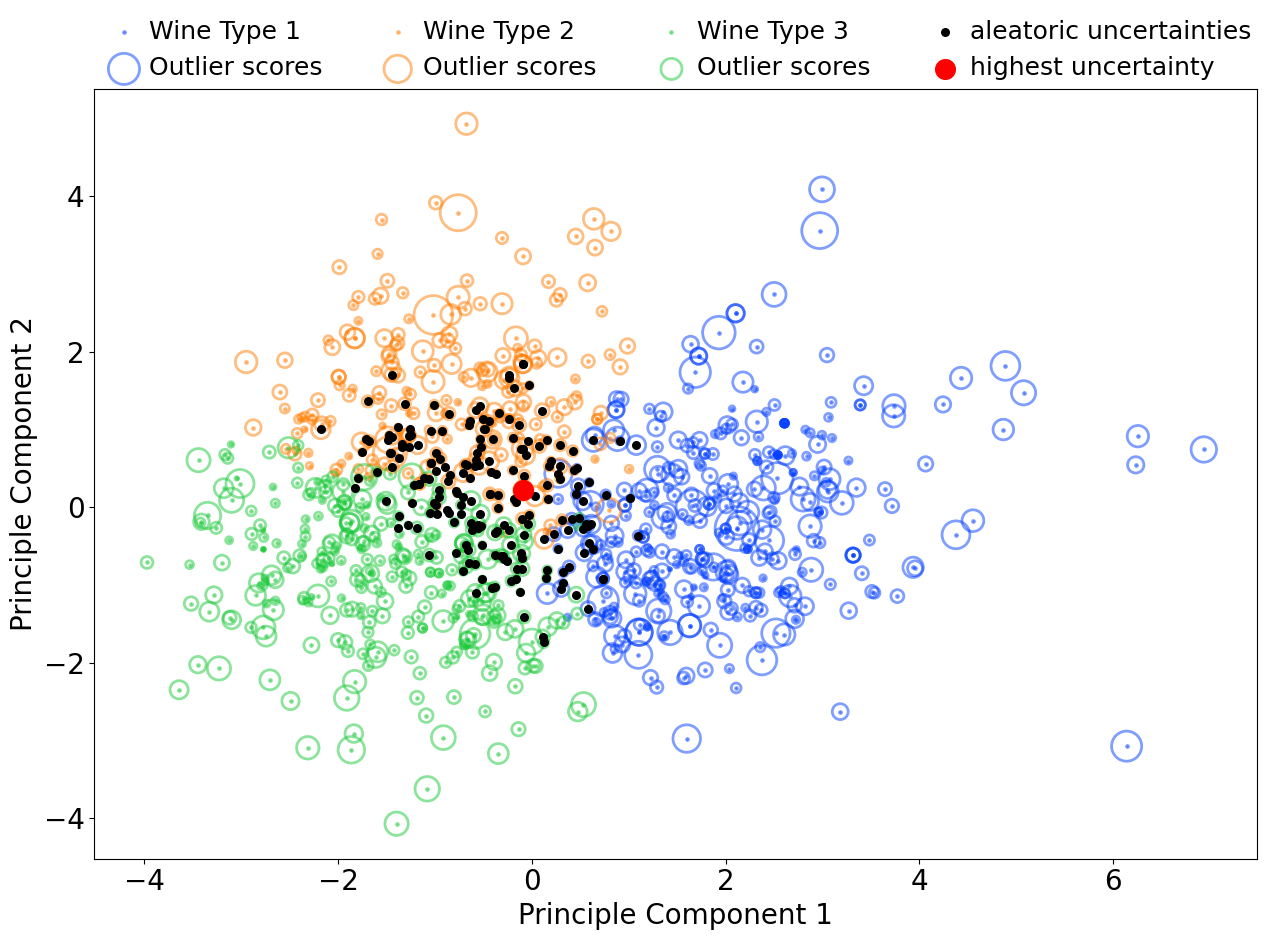

In [70]:
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF_with_highest(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine, uncertainty, selected_uncertainty, 
                     descr="aleatoric uncertainties", descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
plt.show()

# EPISTEMIC AND ALEATORIC

## Model fitting

In [71]:
num_classes=3
T = 30
loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

batch_size = 128
epochs = 20
input_shape = (11)
dropout_p = 0.25
n_hidden = [64, 64]

In [72]:
"""total_mc_model = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,
                           loss=loss_fn, include_logvar=True,
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
total_mc_model.summary()"""


'total_mc_model = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,\n                           loss=loss_fn, include_logvar=True,\n                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))\ntotal_mc_model.summary()'

In [73]:
"""history_total_model = total_mc_model.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_test, y_wine_test_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)"""

'history_total_model = total_mc_model.fit(X_wine_train, y_wine_train_type, \n                       validation_data=(X_wine_test, y_wine_test_type), \n                       batch_size=batch_size, epochs=epochs, verbose=1)'

In [74]:
"""save_model(model=total_mc_model, batch_size=batch_size, n_hidden=n_hidden, 
           n_epochs=epochs, descr="total_mc_model_wine", dropout=dropout_p)"""

'save_model(model=total_mc_model, batch_size=batch_size, n_hidden=n_hidden, \n           n_epochs=epochs, descr="total_mc_model_wine", dropout=dropout_p)'

In [75]:
total_mc_model =  tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models/model_total_mc_model_wine_batchsize128_nepoch20_dropout2.5_nhidden_64_64.h5",
                                          custom_objects={"bayesian_categorical_crossentropy_internal": bayesian_categorical_crossentropy})

In [76]:
"""loss_full_model_eval, accuracy_full_model_eval = total_mc_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)
print(f"Eval loss = {loss_full_model_eval}, Eval accuracy = {accuracy_full_model_eval}")"""

'loss_full_model_eval, accuracy_full_model_eval = total_mc_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)\nprint(f"Eval loss = {loss_full_model_eval}, Eval accuracy = {accuracy_full_model_eval}")'

### Save all accuracies and losses so far

In [77]:
"""all_accuracy = [accuracy_orig_eval, mc_model_accuracy_eval,
                accuracy_alea_model_eval, accuracy_full_model_eval]

all_loss = [loss_orig_eval, loss_mc_model_eval,
            loss_alea_model_eval, loss_full_model_eval]

print(all_accuracy)
print(all_loss)"""

'all_accuracy = [accuracy_orig_eval, mc_model_accuracy_eval,\n                accuracy_alea_model_eval, accuracy_full_model_eval]\n\nall_loss = [loss_orig_eval, loss_mc_model_eval,\n            loss_alea_model_eval, loss_full_model_eval]\n\nprint(all_accuracy)\nprint(all_loss)'

In [78]:
"""fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_accuracy_loss"
savetxt(fp + '/all_accuracy_wine.csv', all_accuracy, delimiter=',')
savetxt(fp + '/all_loss_wine.csv', all_loss, delimiter=',')"""

'fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_accuracy_loss"\nsavetxt(fp + \'/all_accuracy_wine.csv\', all_accuracy, delimiter=\',\')\nsavetxt(fp + \'/all_loss_wine.csv\', all_loss, delimiter=\',\')'

In [79]:
fp = filepath + "/FINAL_accuracy_loss"
all_accuracy = loadtxt(fp+'/all_accuracy_wine.csv', delimiter=',')
all_loss = loadtxt(fp+'/all_loss_wine.csv', delimiter=',')

## accuracy plots

In [80]:
"""loss_accuracy_plot(history_total_model)"""

'loss_accuracy_plot(history_total_model)'

## Calculating epistemic uncertainties

In [81]:
import tqdm
def make_predictions_softmax(model, n_pred=100, val_data=X_wine_test):
  class_predictions = []
  for i in tqdm.tqdm(range(n_pred)):
      full_prediction = tf.convert_to_tensor(model.predict(val_data))
      y_p = tf.keras.activations.softmax(full_prediction[:,:3]).numpy()
      class_predictions.append(y_p)
  return class_predictions

In [82]:
"""mc_predictions_total = make_predictions_softmax(total_mc_model)
mc_ensemble_pred_total, mc_ensemble_acc_total = ensemble_pred(mc_predictions_total)
mc_y_mean_total, mc_y_std_total, mc_epistemic_total = cal_epistemic(mc_predictions_total)"""

'mc_predictions_total = make_predictions_softmax(total_mc_model)\nmc_ensemble_pred_total, mc_ensemble_acc_total = ensemble_pred(mc_predictions_total)\nmc_y_mean_total, mc_y_std_total, mc_epistemic_total = cal_epistemic(mc_predictions_total)'

In [83]:
"""fp = filepath + "/TEST_saved_uncertainties"
savetxt(fp + '/mc_epistemic_total_wine.csv', mc_epistemic_total, delimiter=',')
savetxt(fp + '/mc_y_mean_total_wine.csv', mc_y_mean_total, delimiter=',')
savetxt(fp + '/mc_ensemble_pred_total_wine.csv', mc_ensemble_pred_total, delimiter=',')"""

'fp = filepath + "/TEST_saved_uncertainties"\nsavetxt(fp + \'/mc_epistemic_total_wine.csv\', mc_epistemic_total, delimiter=\',\')\nsavetxt(fp + \'/mc_y_mean_total_wine.csv\', mc_y_mean_total, delimiter=\',\')\nsavetxt(fp + \'/mc_ensemble_pred_total_wine.csv\', mc_ensemble_pred_total, delimiter=\',\')'

In [84]:
fp = filepath + "/TEST_saved_uncertainties"
mc_epistemic_total = loadtxt(fp+'/mc_epistemic_total_wine.csv', delimiter=',')
mc_y_mean_total = loadtxt(fp+'/mc_y_mean_total_wine.csv', delimiter=',')
mc_ensemble_pred_total = loadtxt(fp+'/mc_ensemble_pred_total_wine.csv', delimiter=',')

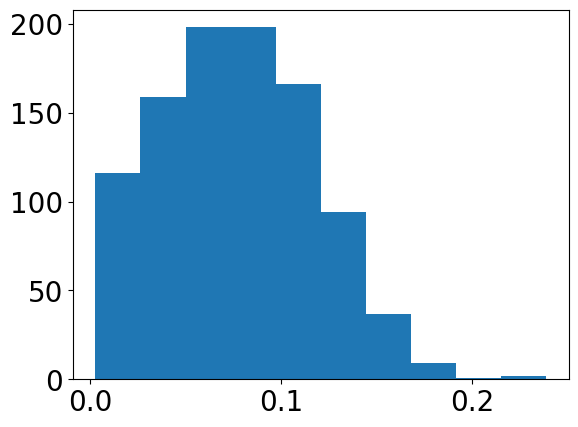

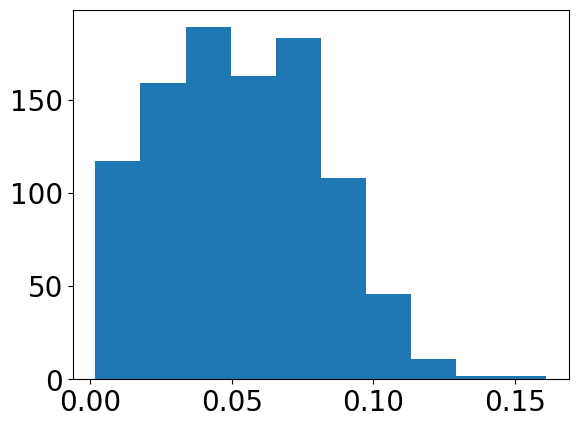

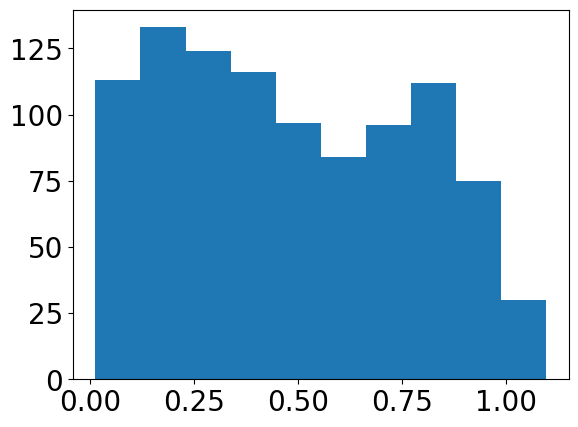

In [85]:
for i in [0,1,2]:
  plt.hist(mc_epistemic_total[i])
  plt.show()

## Calculating aleatoric uncertainties

In [86]:
""""pred_class_alea_total, sigmas_alea_total = cal_aleatoric(total_mc_model)
alea_idx_total = sigmas_alea_total.argsort()[::-1]"""

'"pred_class_alea_total, sigmas_alea_total = cal_aleatoric(total_mc_model)\nalea_idx_total = sigmas_alea_total.argsort()[::-1]'

In [87]:
"""fp = filepath + "/TEST_saved_uncertainties"
savetxt(fp + '/alea_total_wine.csv', sigmas_alea_total, delimiter=',')
savetxt(fp + '/pred_class_alea_total_wine.csv', pred_class_alea_total, delimiter=',')"""

'fp = filepath + "/TEST_saved_uncertainties"\nsavetxt(fp + \'/alea_total_wine.csv\', sigmas_alea_total, delimiter=\',\')\nsavetxt(fp + \'/pred_class_alea_total_wine.csv\', pred_class_alea_total, delimiter=\',\')'

In [88]:
fp = filepath + "/TEST_saved_uncertainties"
sigmas_alea_total = loadtxt(fp+'/alea_total_wine.csv', delimiter=',')
pred_class_alea_total = loadtxt(fp+'/pred_class_alea_total_wine.csv', delimiter=',')

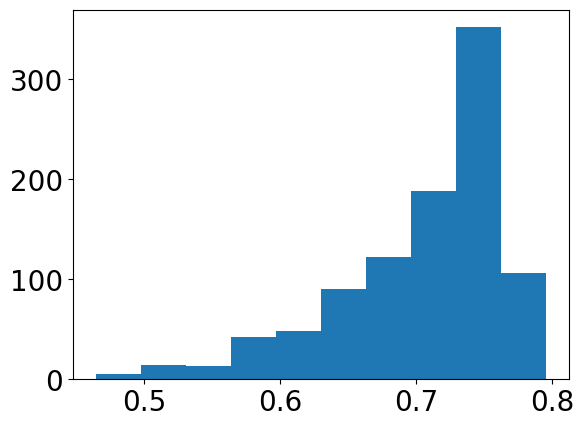

In [89]:
plt.hist(sigmas_alea_total)
plt.show()

## plotting: PCA, epistemic, LOF

In [90]:
epi_idx_total = mc_epistemic_total[2].argsort()[::-1]
highest_epi_total = epi_idx_total[:200]
selected_uncertainty = epi_idx_total[0]

In [91]:
np.intersect1d(outlier_index_wine, highest_epi_total)

array([501, 897])

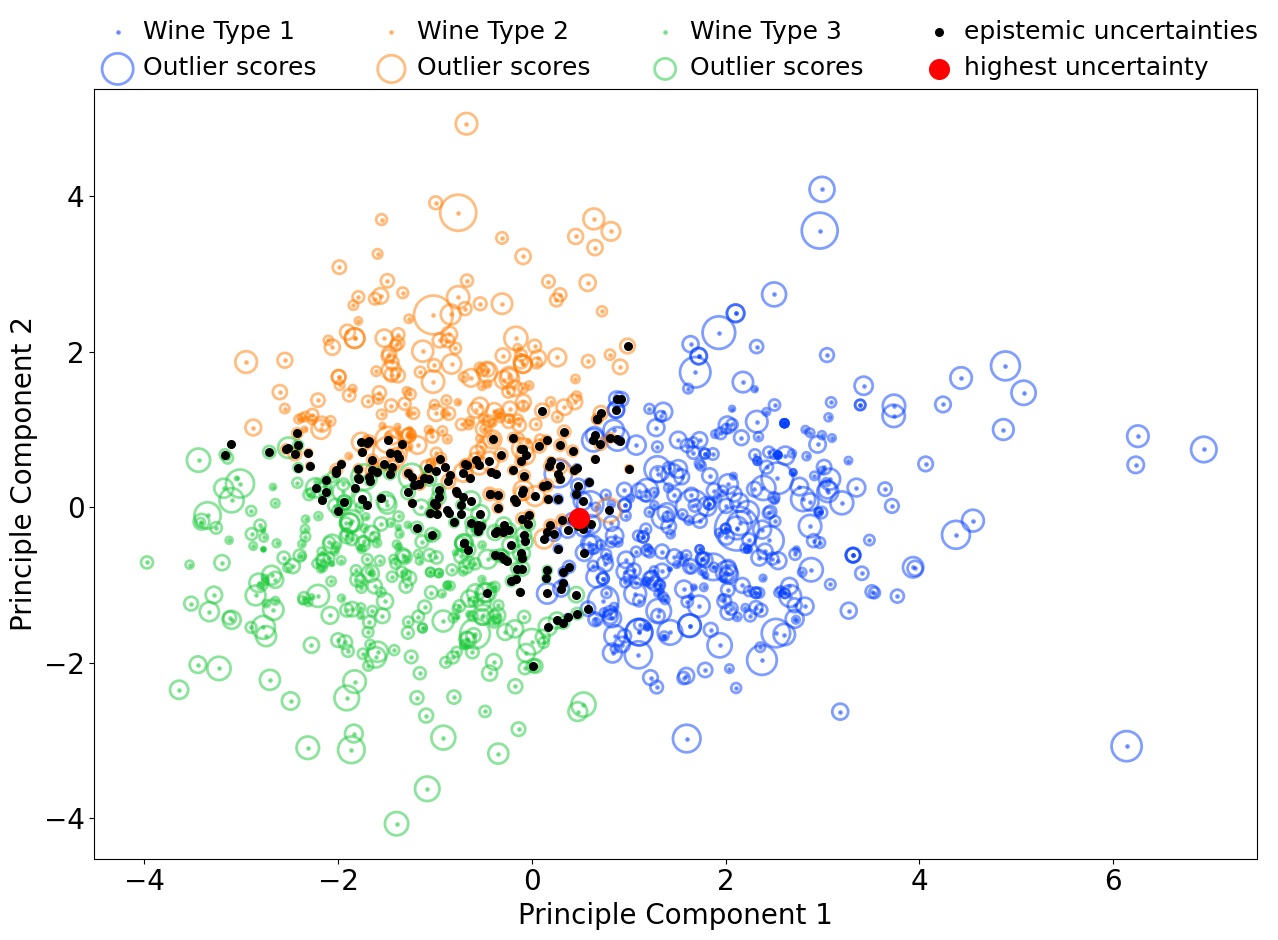

In [92]:
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF_with_highest(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine, highest_epi_total,selected_uncertainty,
                     descr="epistemic uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig('/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_plots/PCA_epistemic_wine.png', 
#            transparent=True, bbox_inches='tight')

plt.show()

## plotting: PCA, aleatoric, LOF

In [93]:
n = 200
alea_idx_total = sigmas_alea_total.argsort()[::-1]
highest_alea_total = alea_idx_total[:n]
selected_uncertainty = alea_idx_total[0]

In [94]:
np.intersect1d(outlier_index_wine, highest_alea_total)

array([216, 501, 643])

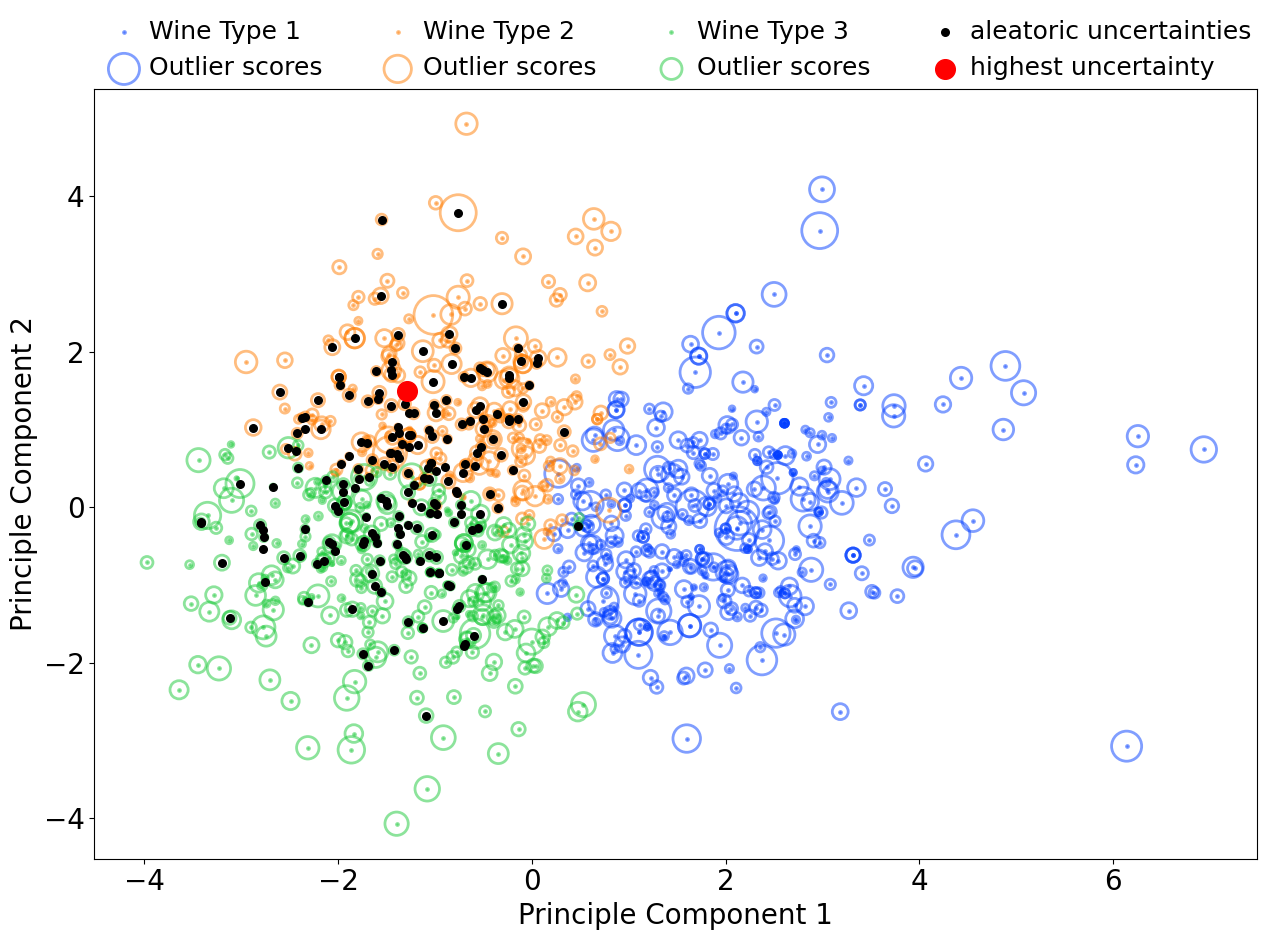

In [95]:
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF_with_highest(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine, highest_alea_total, selected_uncertainty,
                     descr="aleatoric uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
#fig.savefig('/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_plots/PCA_aleatoric_wine.png', 
#            transparent=True, bbox_inches='tight')

plt.show()

# Further visualisations

## effect on accuracy when deleting data points with highest uncertainties

we found that accuracy improved!

In [96]:
"""del_percentage = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
def check_acc(model, uncertainty, 
              del_percentage=del_percentage):
  accuracy_list = []
  loss_list = []
  sorted_uncertainty = uncertainty.argsort()[::-1]
  n = uncertainty.shape[0]
  for d in del_percentage:
      # drop the samples with highest uncertainty
      print(f"delete the {int(n*d)} highest uncertainties")
      drop_highest = sorted_uncertainty[int(n*d):]
      #print(drop_highest)
      loss, accuracy = model.evaluate(X_wine_test.iloc[drop_highest], 
                                      y_wine_test_type[drop_highest], 
                                      verbose=0)
      print(f"Eval loss = {loss}, Eval accuracy = {accuracy}")
      loss_list.append(loss)
      accuracy_list.append(accuracy)
  return loss_list, accuracy_list"""

'del_percentage = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]\ndef check_acc(model, uncertainty, \n              del_percentage=del_percentage):\n  accuracy_list = []\n  loss_list = []\n  sorted_uncertainty = uncertainty.argsort()[::-1]\n  n = uncertainty.shape[0]\n  for d in del_percentage:\n      # drop the samples with highest uncertainty\n      print(f"delete the {int(n*d)} highest uncertainties")\n      drop_highest = sorted_uncertainty[int(n*d):]\n      #print(drop_highest)\n      loss, accuracy = model.evaluate(X_wine_test.iloc[drop_highest], \n                                      y_wine_test_type[drop_highest], \n                                      verbose=0)\n      print(f"Eval loss = {loss}, Eval accuracy = {accuracy}")\n      loss_list.append(loss)\n      accuracy_list.append(accuracy)\n  return loss_list, accuracy_list'

In [97]:
"""loss_list_total_mc, accuracy_list_total_mc = check_acc(model=total_mc_model, 
                                                        uncertainty=mc_epistemic_total[2])"""

'loss_list_total_mc, accuracy_list_total_mc = check_acc(model=total_mc_model, \n                                                        uncertainty=mc_epistemic_total[2])'

In [98]:
"""plt.plot(del_percentage, accuracy_list_total_mc)
plt.scatter(del_percentage, accuracy_list_total_mc)
plt.show()

plt.plot(del_percentage, loss_list_total_mc)
plt.scatter(del_percentage, loss_list_total_mc)
plt.show()"""

'plt.plot(del_percentage, accuracy_list_total_mc)\nplt.scatter(del_percentage, accuracy_list_total_mc)\nplt.show()\n\nplt.plot(del_percentage, loss_list_total_mc)\nplt.scatter(del_percentage, loss_list_total_mc)\nplt.show()'

In [99]:
"""loss_list_total_mc_alea, accuracy_list_total_mc_alea = check_acc(model=total_mc_model, 
                                                        uncertainty=sigmas_alea_total)"""

'loss_list_total_mc_alea, accuracy_list_total_mc_alea = check_acc(model=total_mc_model, \n                                                        uncertainty=sigmas_alea_total)'

In [100]:
"""plt.plot(del_percentage, accuracy_list_total_mc_alea)
plt.scatter(del_percentage, accuracy_list_total_mc_alea)
plt.show()

plt.plot(del_percentage, loss_list_total_mc_alea)
plt.scatter(del_percentage, loss_list_total_mc_alea)
plt.show()"""

'plt.plot(del_percentage, accuracy_list_total_mc_alea)\nplt.scatter(del_percentage, accuracy_list_total_mc_alea)\nplt.show()\n\nplt.plot(del_percentage, loss_list_total_mc_alea)\nplt.scatter(del_percentage, loss_list_total_mc_alea)\nplt.show()'

## compare feature of high uncertainty to feature distributions

In [101]:
# we need unnormaliesed feature matrix
(_,_,_,_,
  X_wine_test_original, _, _,
  _,_,_,
  _,_,_) = get_wine_data()

In [102]:
def feat_dist_uncert(selected_uncertainty):
  feat_uncerts = X_wine_test_original.iloc[selected_uncertainty] # features of selected wine
  wine = y_wine_test_type_original.iloc[selected_uncertainty] # class of selected wine
  print(f"uncertainty {selected_uncertainty}, wine type {wine} with the following features:\n")
  print(feat_uncerts)
  fig, axs = plt.subplots(4,3,figsize=(12,12))
  for ax, var, feat_uncert in zip(axs.reshape(-1), df_wine.iloc[:, :-2], feat_uncerts): 
          wine = wine
          mask = df_wine["type"]==wine
          plot_data = df_wine.loc[mask,]
          sns.distplot(plot_data[var], ax=ax, label="wine "+ str(wine), color="grey")
          ax.axvline(feat_uncert, color="red")
          ax.set_title(var)
          ax.set_xlabel('')
          #ax.set_ylabel('Density')

  axs[0,0].set_ylabel('Density')
  axs[1,0].set_ylabel('Density')
  axs[2,0].set_ylabel('Density')
  axs[3,0].set_ylabel('Density')
  fig.tight_layout(pad=3.0)
  axs[-1, -1].axis('off')   

  # axs[0,0].legend(ncol=6, bbox_to_anchor=(0.5, 0.93), bbox_transform=fig.transFigure, loc='center', frameon=False)
  axs[0,0].legend(bbox_to_anchor=(0.5, 1), loc='center', bbox_transform=fig.transFigure,
                frameon=False, ncol=3)

  [ax.legend().remove() for ax in axs.reshape(-1)[1:]];

  plt.show()

this is how the features distribution of the sample with highest epistemic uncertainty looks like

uncertainty 448, wine type 2 with the following features:

fixed.acidity             6.5000
volatile.acidity          0.3400
citric.acid               0.2800
residual.sugar            1.8000
chlorides                 0.0410
free.sulfur.dioxide      43.0000
total.sulfur.dioxide    188.0000
density                   0.9928
pH                        3.1300
sulphates                 0.3700
alcohol                   9.6000
Name: 966, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

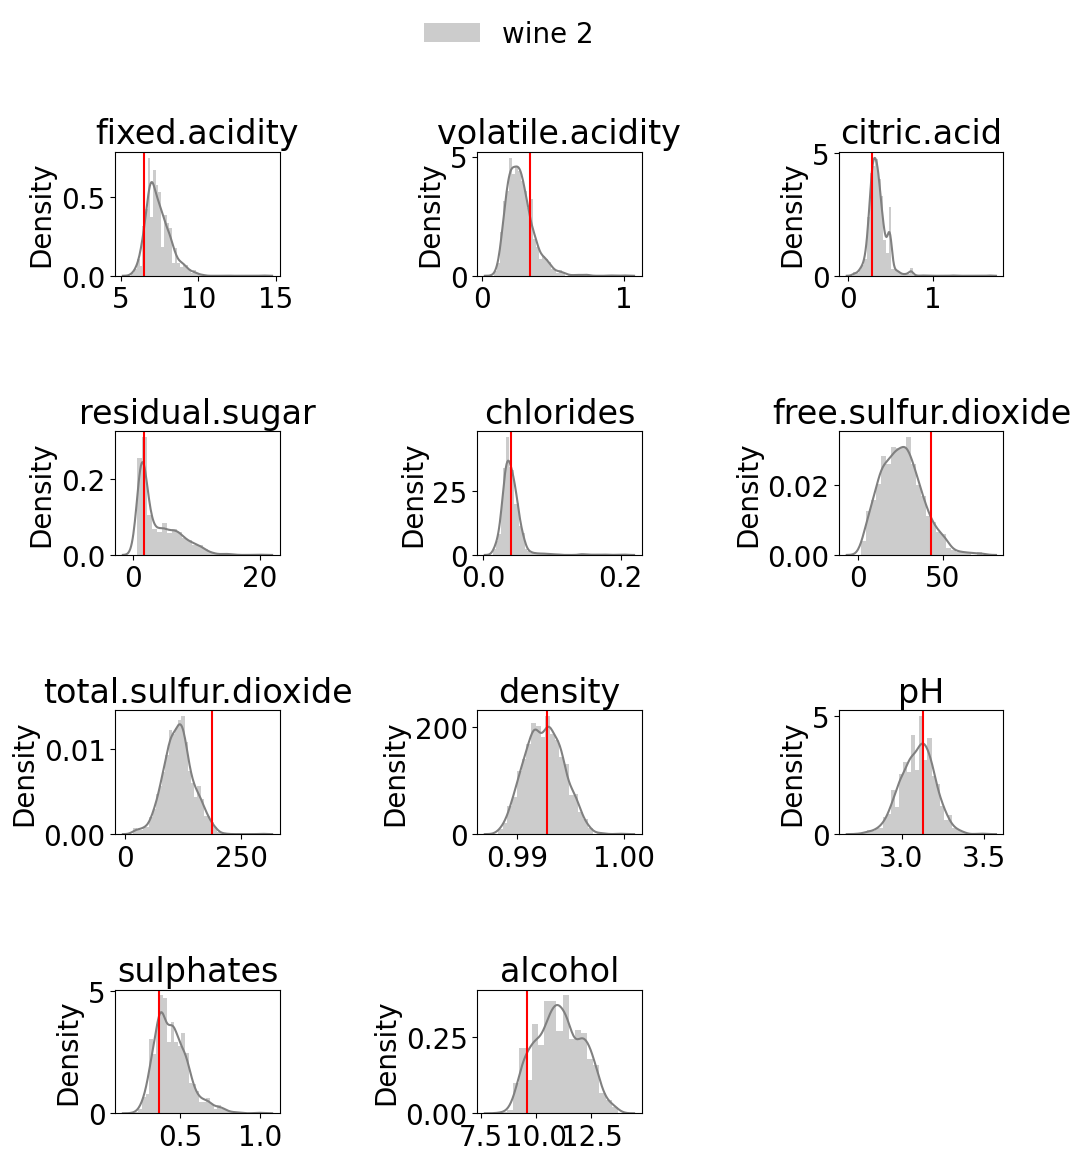

In [103]:
highest_epis = mc_epistemic[2].argsort()[::-1]
selected_uncertainty = highest_epis[0]
feat_dist_uncert(selected_uncertainty)

this is how the features distribution of the sample with lowest epistemic uncertainty looks like

uncertainty 205, wine type 1 with the following features:

fixed.acidity             6.2000
volatile.acidity          0.3700
citric.acid               0.3000
residual.sugar            6.6000
chlorides                 0.3460
free.sulfur.dioxide      79.0000
total.sulfur.dioxide    200.0000
density                   0.9954
pH                        3.2900
sulphates                 0.5800
alcohol                   9.6000
Name: 484, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

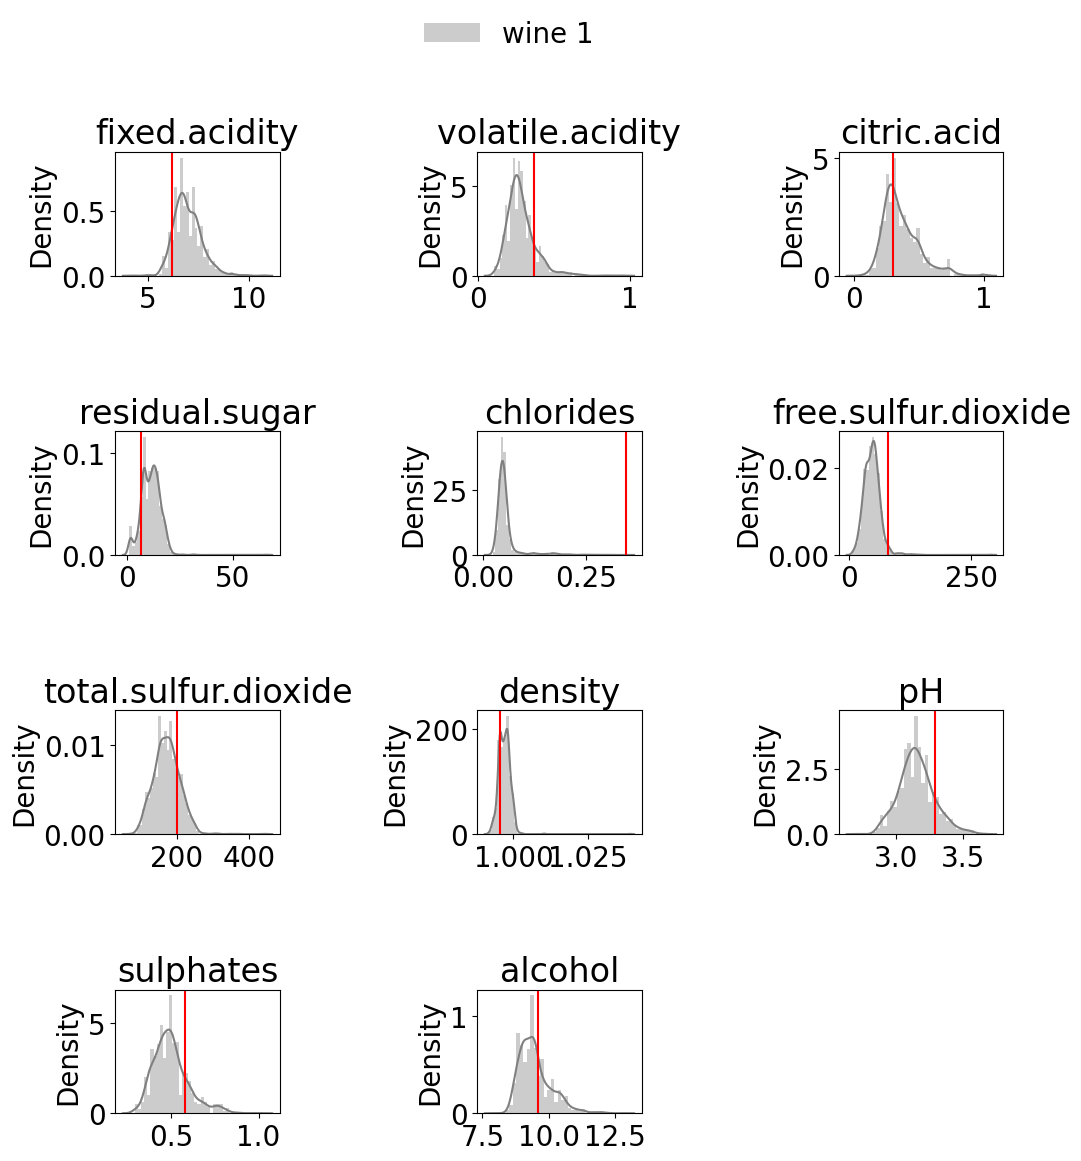

In [104]:
lowest_epis = mc_epistemic_total[2].argsort()
selected_uncertainty = lowest_epis[0]
feat_dist_uncert(selected_uncertainty)

this is how the features distribution of the sample with highest aleatoric uncertainty looks like

uncertainty 165, wine type 2 with the following features:

fixed.acidity             7.700
volatile.acidity          0.270
citric.acid               0.350
residual.sugar            5.300
chlorides                 0.030
free.sulfur.dioxide      30.000
total.sulfur.dioxide    117.000
density                   0.992
pH                        3.110
sulphates                 0.420
alcohol                  12.200
Name: 655, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

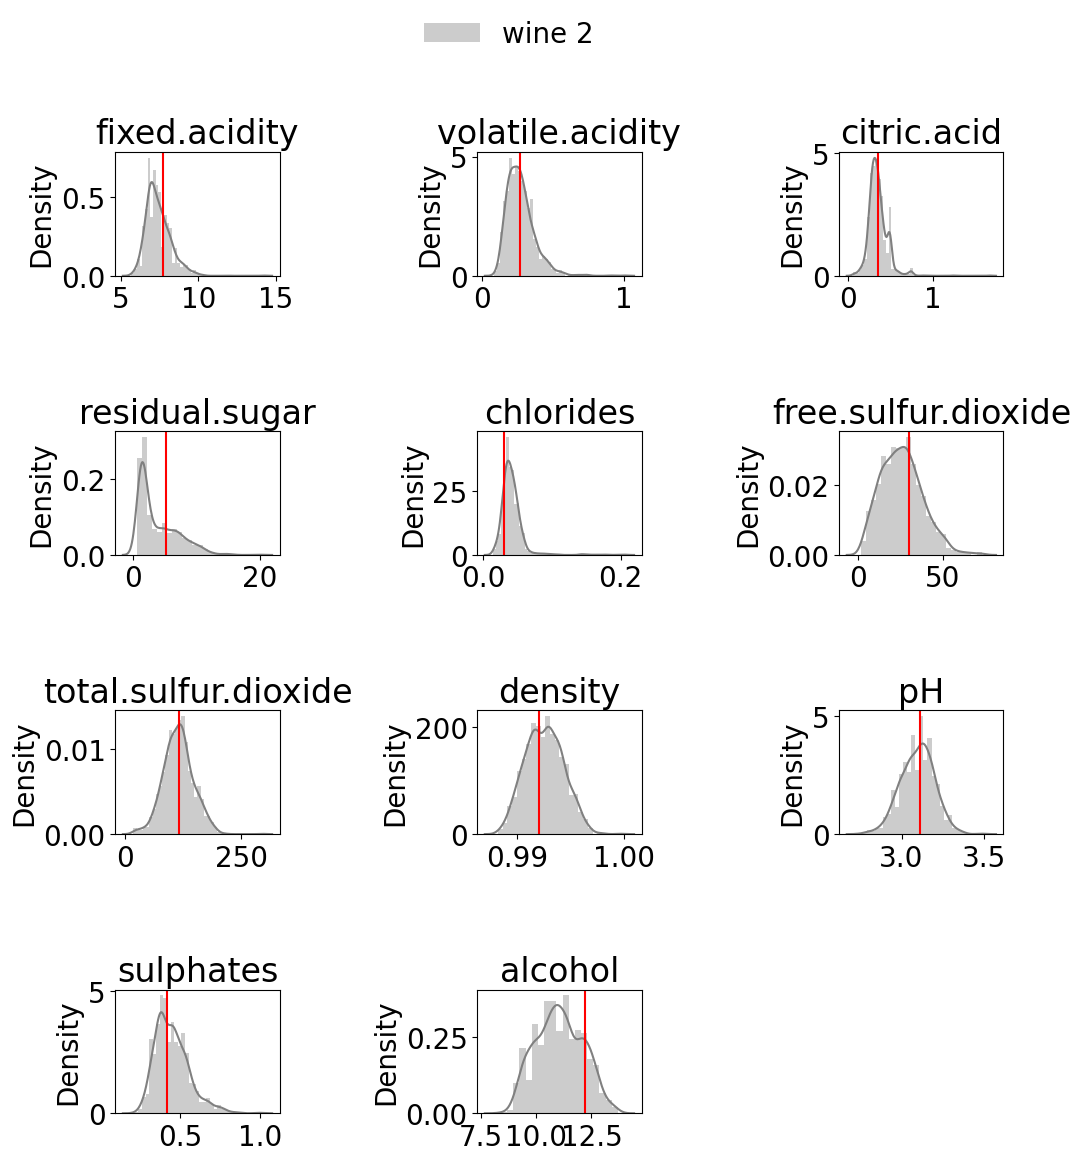

In [105]:
highest_alea = sigmas_alea_total.argsort()[::-1]
selected_uncertainty = highest_alea[0]
feat_dist_uncert(selected_uncertainty)

this is how the features distribution of the sample with lowest aleatoric uncertainty looks like

uncertainty 423, wine type 1 with the following features:

fixed.acidity             7.9000
volatile.acidity          0.6400
citric.acid               0.4600
residual.sugar           10.6000
chlorides                 0.2440
free.sulfur.dioxide      33.0000
total.sulfur.dioxide    227.0000
density                   0.9983
pH                        2.8700
sulphates                 0.7400
alcohol                   9.1000
Name: 1034, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

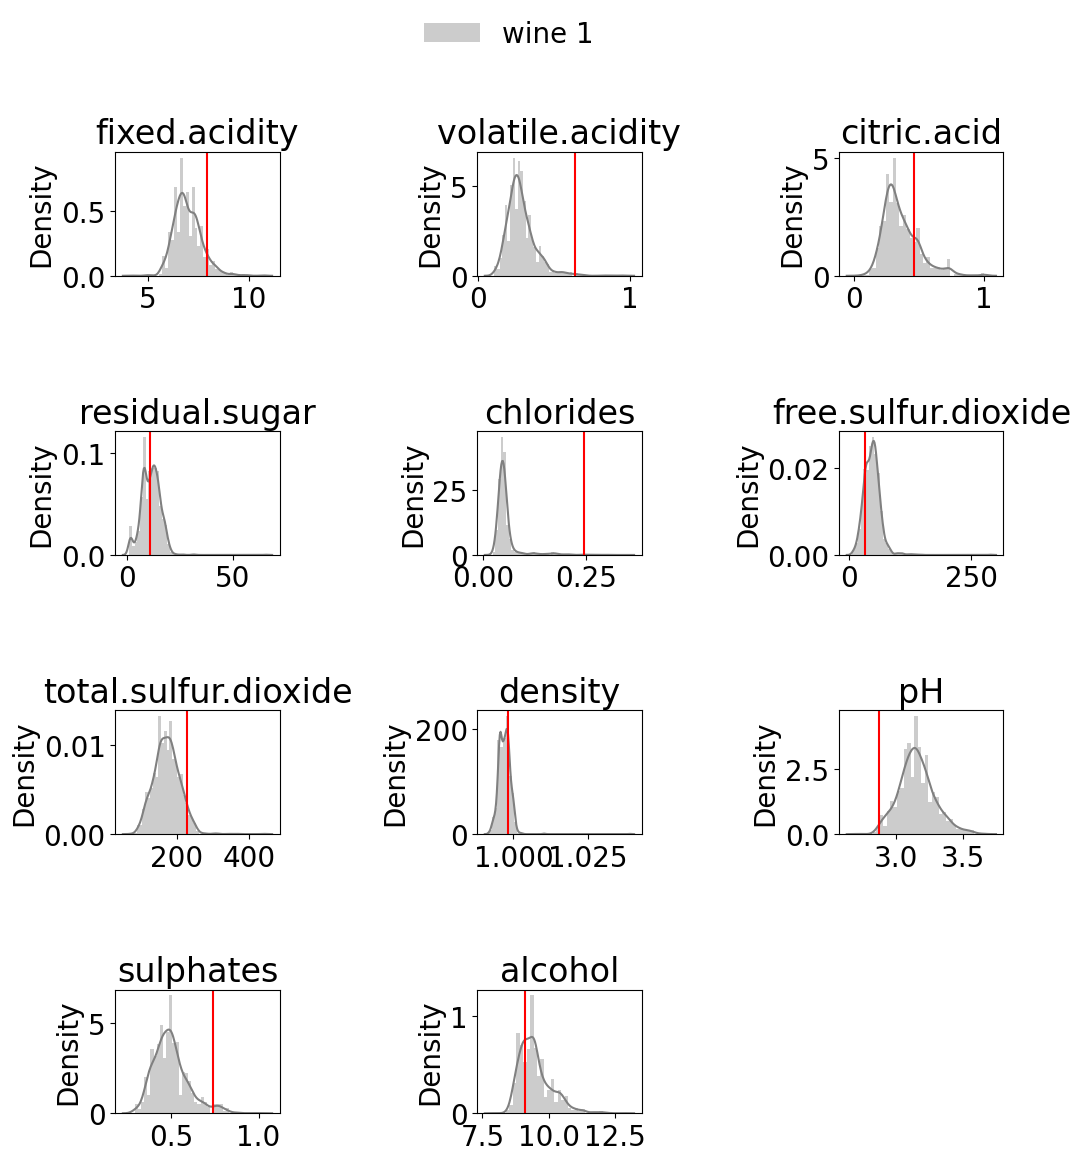

In [106]:
lowest_alea = sigmas_alea_total.argsort()
selected_uncertainty = lowest_alea[0]
feat_dist_uncert(selected_uncertainty)

there did not seem to be a correlation between unusual features and the level of uncertainty

# Check loss attenuation

Gal et al. argue that with the provided loss function, the loss for wrongly classified samples is attenuated by giving these predictions high aleatoric uncertainties 

So we ask the question: how many wrongly classified images are among the n predictions with highest aleatoric uncertainty?

In [107]:
def loss_att_check(sigmas, predicted_class, highest=True, n_alea=20,
                   x_data=X_wine_test):
  #fig, axs = plt.subplots(4, 5, figsize=(8,8)) 
  if highest == True:
    alea_idx = sigmas.argsort()[::-1]
  if highest == False:
    alea_idx = sigmas.argsort()
  # only consider n top aleatoric indices 
  alea_idx = alea_idx[:n_alea]
  # convert predicted 0,1,2,3 to 0,1,7,8
  #converted_pred = np.array([class_converter(i) for i in predicted_class])
  # number and idx of missclassified
  n_wrongclass_highalea = sum(predicted_class[alea_idx] != np.array(y_wine_test_type_original-1)[alea_idx])
  wrongclass_highalea_idx = np.where(predicted_class[alea_idx] != np.array(y_wine_test_type_original-1)[alea_idx])[0]
  # true and predicted labsl of missclassified
  pred_label = (predicted_class[alea_idx])[wrongclass_highalea_idx]
  true_label = (np.array(y_wine_test_type_original-1)[alea_idx])[wrongclass_highalea_idx]
  return n_wrongclass_highalea, alea_idx[wrongclass_highalea_idx], true_label, pred_label

In [108]:
# 13 missclassifcations
sum(pred_class_alea != np.array(y_wine_test_type_original-1))

13

In [109]:
# in 980 predictions
pred_class_alea.shape[0]

980

In [110]:
(n_wrongclass_highalea, alea_idx, 
 true_label, pred_label) = loss_att_check(sigmas_alea, pred_class_alea,
                            n_alea=245) #n_alea=2953)
                            
print(n_wrongclass_highalea, alea_idx, true_label, pred_label)

8 [147 448 770  20 876 908 393 414] [1 1 2 2 2 1 0 2] [0. 2. 1. 1. 1. 2. 2. 1.]


In [111]:
n_wrongclass_highalea/sum(pred_class_alea != np.array(y_wine_test_type_original-1))

0.6153846153846154

the above implies that within the top 25% of predictions with highest aleatoric uncertainty, 62% of the misclassified observations were present

# Overlap data points with highest uncertainties when using different models/calculations?

We modeled epistemic and aleatoric uncertainties separately but also jointly. Now let's see if there is an overlap in the predictions with highest uncertainty

## Epistemic

In [112]:
# checking which samples overlap with the different types of calculating 
# epistemic uncertainty
def overlap_epistemic(all_epi, highest=True, n_epi=20):
    if highest == True:
      epi_0_idx = all_epi[0].argsort()[::-1]
      epi_1_idx = all_epi[1].argsort()[::-1]
      epi_2_idx = all_epi[2].argsort()[::-1]
    if highest == False:
      epi_0_idx = all_epi[0].argsort()
      epi_1_idx = all_epi[1].argsort()
      epi_2_idx = all_epi[2].argsort()
    overlap01 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_1_idx[:n_epi]])))
    overlap12 = list(set.intersection(*map(set, [epi_1_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))   
    overlap02 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))   
    overlap012 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_1_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))
    return overlap01, overlap12, overlap02, overlap012

In [113]:
# model only epistemic
n_epi = 100
overlap01, overlap12, overlap02, overlap012 = overlap_epistemic(mc_epistemic,
                                                                n_epi=n_epi, highest=False)
print("std max and mean:\n", overlap01,
    "\nstd mean and entropy: \n", overlap12,
    "\nstd max and entropy: \n", overlap02,
    "\nall three:\n", overlap012,
    "\npercentage of all overlap: ", len(overlap012)/n_epi)

std max and mean:
 [512, 2, 13, 22, 537, 540, 542, 550, 554, 563, 52, 61, 69, 592, 81, 614, 622, 629, 638, 128, 653, 654, 657, 658, 662, 153, 154, 672, 674, 162, 168, 684, 174, 686, 194, 202, 204, 205, 719, 209, 210, 215, 216, 222, 225, 228, 230, 742, 744, 748, 752, 755, 763, 768, 777, 270, 782, 276, 788, 795, 802, 291, 293, 296, 298, 810, 814, 817, 322, 335, 342, 865, 355, 868, 874, 365, 368, 881, 884, 885, 902, 910, 911, 918, 408, 423, 424, 937, 425, 950, 955, 956, 959, 459, 460, 974, 463, 472, 479, 496] 
std mean and entropy: 
 [512, 2, 13, 22, 537, 540, 542, 550, 563, 69, 592, 614, 622, 629, 638, 128, 653, 654, 657, 662, 153, 154, 674, 162, 168, 174, 686, 194, 202, 204, 205, 719, 210, 215, 216, 222, 225, 228, 230, 744, 752, 763, 768, 777, 782, 270, 276, 788, 795, 802, 291, 296, 810, 814, 817, 342, 865, 355, 868, 874, 365, 368, 884, 885, 902, 910, 911, 918, 408, 423, 424, 937, 425, 950, 955, 956, 959, 459, 460, 974, 463, 479, 496] 
std max and entropy: 
 [512, 2, 13, 22, 537, 540, 5

In [114]:
# model both aleatoric and epistemic
n_epi = 100
overlap01, overlap12, overlap02, overlap012 = overlap_epistemic(mc_epistemic_total,
                                                                n_epi=n_epi, highest=False)
print("std max and mean:\n", overlap01,
    "\nstd mean and entropy: \n", overlap12,
    "\nstd max and entropy: \n", overlap02,
    "\nall three:\n", overlap012,
    "\npercentage of all overlap: ", len(overlap012)/n_epi)

std max and mean:
 [512, 2, 524, 12, 13, 22, 537, 540, 542, 543, 550, 563, 75, 587, 592, 616, 622, 629, 125, 638, 128, 653, 654, 657, 658, 662, 153, 154, 161, 674, 162, 170, 686, 175, 174, 690, 190, 713, 204, 205, 719, 209, 215, 222, 225, 228, 230, 231, 744, 752, 757, 763, 768, 256, 777, 782, 270, 276, 790, 802, 291, 293, 296, 814, 817, 319, 322, 838, 334, 342, 865, 353, 355, 868, 874, 368, 883, 884, 885, 902, 391, 910, 405, 918, 423, 424, 937, 425, 434, 950, 955, 956, 959, 449, 450, 459, 460, 479, 506] 
std mean and entropy: 
 [512, 2, 13, 22, 537, 540, 542, 550, 563, 592, 616, 622, 629, 638, 128, 653, 654, 657, 658, 662, 153, 154, 674, 162, 170, 686, 175, 190, 713, 204, 205, 719, 209, 215, 225, 228, 230, 231, 744, 752, 757, 763, 768, 256, 777, 782, 270, 276, 790, 802, 291, 293, 296, 814, 817, 322, 838, 334, 342, 865, 355, 868, 874, 368, 884, 885, 902, 391, 910, 918, 423, 424, 425, 434, 950, 955, 956, 959, 449, 459, 460, 479, 506] 
std max and entropy: 
 [512, 2, 13, 22, 537, 540, 542

## Overlap between models

Do the different models give high uncertainties to the same predictions?

In [115]:
def overlap_models(uncertain_1, uncertain_2, highest=True, n=20):
    if highest == True:
      uncertain_1_idx = uncertain_1.argsort()[::-1]
      uncertain_2_idx = uncertain_2.argsort()[::-1]
    if highest == False:
      uncertain_1_idx = uncertain_1.argsort()
      uncertain_2_idx = uncertain_2.argsort()
    overlap = list(set.intersection(*map(set, [uncertain_1_idx[:n], 
                                               uncertain_2_idx[:n]])))
    return overlap

In [116]:
# models including epistemic uncertainty 
n = int(mc_epistemic[2].shape[0] * 0.10)
overlap_epi = overlap_models(mc_epistemic[2], mc_epistemic_total[2],
                         n=n)
print("percentage of overlap: ", len(overlap_epi)/n, 
      "\nnumber of overlaps: ", len(overlap_epi),
      "\noverlap:\n", overlap_epi)

percentage of overlap:  0.8469387755102041 
number of overlaps:  83 
overlap:
 [5, 519, 11, 20, 533, 556, 558, 562, 573, 65, 76, 601, 98, 99, 619, 620, 631, 642, 649, 139, 142, 147, 149, 668, 671, 681, 693, 187, 206, 208, 217, 732, 733, 735, 236, 750, 243, 248, 249, 770, 774, 780, 268, 785, 280, 302, 305, 819, 316, 830, 320, 327, 846, 337, 338, 341, 357, 878, 377, 381, 894, 897, 385, 390, 393, 908, 399, 403, 922, 414, 419, 932, 934, 428, 946, 442, 447, 448, 963, 967, 503, 507, 510]


In [117]:
n = int(mc_epistemic[2].shape[0] * 0.10)
overlap_alea = overlap_models(sigmas_alea, sigmas_alea_total,
                         n=n)
print("percentage of overlap: ", len(overlap_alea)/n, 
      "\nnumber of overlaps: ", len(overlap_alea),
      "\noverlap:\n", overlap_alea)

percentage of overlap:  0.15306122448979592 
number of overlaps:  15 
overlap:
 [192, 520, 409, 76, 431, 144, 113, 341, 534, 694, 121, 442, 91, 699, 159]


# Ranges of uncertainties with different model

In [118]:
print(f"M1: epistemic uncertainty ranging from {np.min(mc_epistemic[2]):.3} to {np.max(mc_epistemic[2]):.3}")
print(f"M3: epistemic uncertainty ranging from {np.min(mc_epistemic_total[2]):.3} to {np.max(mc_epistemic_total[2]):.3}")

print(f"M2: alearoric uncertainty ranging from {np.min(sigmas_alea):.3} to {np.max(sigmas_alea):.3}")
print(f"M3: aleatoric uncertainty ranging from {np.min(sigmas_alea_total):.3} to {np.max(sigmas_alea_total):.3}")

M1: epistemic uncertainty ranging from 0.0158 to 1.1
M3: epistemic uncertainty ranging from 0.0129 to 1.1
M2: alearoric uncertainty ranging from 0.000817 to 0.578
M3: aleatoric uncertainty ranging from 0.464 to 0.796


# Comparing performance of the models for both data sets

In [119]:
fp = filepath + "/FINAL_accuracy_loss"
all_accuracy_wine = loadtxt(fp+'/all_accuracy_wine.csv', delimiter=',')
all_loss_wine = loadtxt(fp+'/all_loss_wine.csv', delimiter=',')
all_accuracy_mnist = loadtxt(fp+'/all_accuracy_mnist.csv', delimiter=',')
all_loss_mnist = loadtxt(fp+'/all_loss_mnist.csv', delimiter=',')

In [120]:
table1 = pd.DataFrame(dict(Wine=['Baseline NN', '+ Epistemic Uncertainty',
                                 '+ Aleatoric Uncertainty', 
                                 '+ Epistemic & Aleatoric'],
                  Accuracy=np.round_(all_accuracy_wine, 4)*100,
                  Loss=np.round_(all_loss_wine, 4)))
print(table1.to_latex(index=False)) 

\begin{tabular}{lrr}
\toprule
                    Wine &  Accuracy &    Loss \\
\midrule
             Baseline NN &     99.18 &  0.0400 \\
 + Epistemic Uncertainty &     95.41 &  0.5706 \\
 + Aleatoric Uncertainty &     98.67 &  0.0379 \\
 + Epistemic \& Aleatoric &     95.31 &  0.5650 \\
\bottomrule
\end{tabular}



In [121]:
table2 = pd.DataFrame(dict(MNIST=['Baseline CNN', '+ Epistemic Uncertainty',
                                 '+ Aleatoric Uncertainty', 
                                 '+ Epistemic & Aleatoric'],
                  Accuracy=np.round_(all_accuracy_mnist, 4)*100,
                  Loss=np.round_(all_loss_mnist, 4)))
print(table2.to_latex(index=False)) 

\begin{tabular}{lrr}
\toprule
                   MNIST &  Accuracy &    Loss \\
\midrule
            Baseline CNN &     99.42 &  0.0355 \\
 + Epistemic Uncertainty &     99.22 &  0.0731 \\
 + Aleatoric Uncertainty &     99.36 &  0.0290 \\
 + Epistemic \& Aleatoric &     99.22 &  0.0740 \\
\bottomrule
\end{tabular}



In [122]:
# 99.84
# EnsNet (Ensemble learning in CNN augmented with fully connected subnetworks)

# Effect of increase in training size on uncertainty

Epistemic

In [123]:
#fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/TEST_saved_uncertainties"
#savetxt(fp + '/epi_decreasetrain_mean_list_wine.csv', epi_mean_list, delimiter=',')

In [124]:
fp = filepath + "/TEST_saved_uncertainties"
epi_mean_list = loadtxt(fp+'/epi_decreasetrain_mean_list_wine.csv', delimiter=',')

In [125]:
sample_sizes = [1/8, 1/4, 1/2]

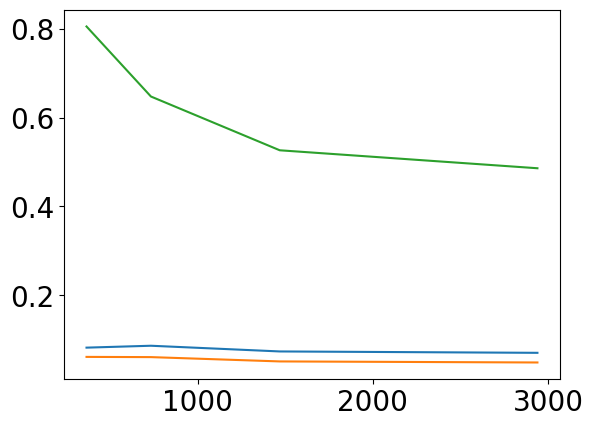

In [126]:
x_samples = [i * X_wine_train.shape[0] for i in sample_sizes] 
x_samples.append(X_wine_train.shape[0])
for i in range(len(epi_mean_list[0])):
  y_epi = [epi[i] for epi in epi_mean_list]
  plt.plot(x_samples, y_epi)
plt.show()

Aleatoric


In [127]:
#fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/TEST_saved_uncertainties"
#savetxt(fp + '/sigmas_decreasetrain_mean_list_wine.csv', sigmas_mean_list, delimiter=',')

In [128]:
fp = filepath + "/TEST_saved_uncertainties"
sigmas_mean_list = loadtxt(fp+'/sigmas_decreasetrain_mean_list_wine.csv', delimiter=',')

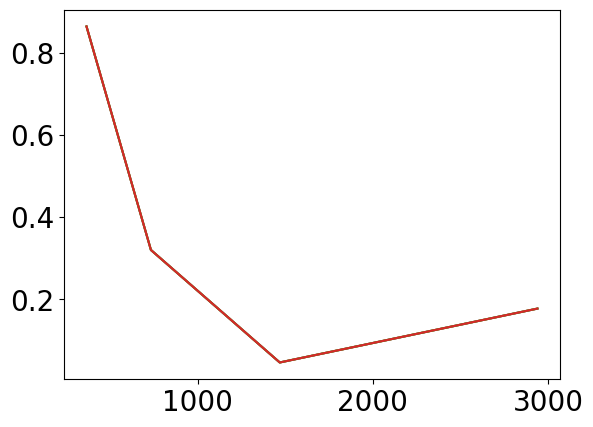

In [129]:
x_samples = [i * X_wine_train.shape[0] for i in sample_sizes] 
x_samples.append(X_wine_train.shape[0])
for i in range(len(sigmas_mean_list)):
  plt.plot(x_samples, sigmas_mean_list)
plt.show()

In [130]:
table3 = pd.DataFrame(dict(Train_set=['Wine', 'Wine / 2',
                                 'Wine / 4', 
                                 'Wine / 8'],
                  Epistemic=np.round_([epi[2] for epi in epi_mean_list][::-1]  , 4),
                  Aleatoric=np.round_(sigmas_mean_list[::-1] , 4),
                  Aleatoric2=np.round([0.51731575, 0.93636525, 0.52985305, 0.17727977][::-1],4)))
print(table3.to_latex(index=False)) 

\begin{tabular}{lrrr}
\toprule
Train\_set &  Epistemic &  Aleatoric &  Aleatoric2 \\
\midrule
     Wine &     0.4860 &     0.1773 &      0.1773 \\
 Wine / 2 &     0.5265 &     0.0461 &      0.5299 \\
 Wine / 4 &     0.6477 &     0.3199 &      0.9364 \\
 Wine / 8 &     0.8055 &     0.8638 &      0.5173 \\
\bottomrule
\end{tabular}



# Quality of classification


code for reliablity plots and ECE from this [github repository](https://github.com/hollance/reliability-diagrams/blob/master/reliability_diagrams.py)



In [131]:
import os
import numpy as np
import matplotlib.pyplot as plt


def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.
    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.
    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float)
    bin_confidences = np.zeros(num_bins, dtype=np.float)
    bin_counts = np.zeros(num_bins, dtype=np.int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }


def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])


def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(np.int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig


def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.
    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.
    The black line is the accuracy, the other end of the bar is the confidence.
    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.
    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.
    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


def reliability_diagrams(results, num_bins=10,
                         draw_ece=True, draw_bin_importance=False, 
                         num_cols=4, dpi=72, return_fig=False):
    """Draws reliability diagrams for one or more models.
    
    Arguments:
        results: dictionary where the key is the model name and the value is
            a dictionary containing the true labels, predicated labels, and
            confidences for this model
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        num_cols: how wide to make the plot
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    ncols = num_cols
    nrows = (len(results) + ncols - 1) // ncols
    figsize = (ncols * 4, nrows * 4)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, 
                           figsize=figsize, dpi=dpi, constrained_layout=True)

    for i, (plot_name, data) in enumerate(results.items()):
        y_true = data["true_labels"]
        y_pred = data["pred_labels"]
        y_conf = data["confidences"]
        
        bin_data = compute_calibration(y_true, y_pred, y_conf, num_bins)
        
        row = i // ncols
        col = i % ncols
        _reliability_diagram_subplot(ax[row, col], bin_data, draw_ece, 
                                     draw_bin_importance, 
                                     title="\n".join(plot_name.split()),
                                     xlabel="Confidence" if row == nrows - 1 else "",
                                     ylabel="Expected Accuracy" if col == 0 else "")

    for i in range(i + 1, nrows * ncols):
        row = i // ncols
        col = i % ncols        
        ax[row, col].axis("off")
        
    plt.show()

    if return_fig: return fig

In [132]:
def betterstep_new(bins, y1, y2, y3, y4, **kwargs):
    """A 'better' version of matplotlib's step function
    
    Given a set of bin edges and bin heights, this plots the thing
    that I wish matplotlib's ``step`` command plotted. All extra
    arguments are passed directly to matplotlib's ``plot`` command.
    
    Args:
        bins: The bin edges. This should be one element longer than
            the bin heights array ``y``.
        y: The bin heights.
        ax (Optional): The axis where this should be plotted.
    
    """
    new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
    new_y1 = [a for row in zip(y1, y1) for a in row]
    new_y2 = [a for row in zip(y2, y2) for a in row]
    new_y3 = [a for row in zip(y3, y3) for a in row]
    new_y4 = [a for row in zip(y4, y4) for a in row]    
    ax = kwargs.pop("ax", plt.gca())
    ax.plot(new_x, new_y1, label="Orig model", **kwargs)
    ax.plot(new_x, new_y2, label="MC model", **kwargs)
    ax.plot(new_x, new_y3, label="Alea model", **kwargs)
    ax.plot(new_x, new_y4, label="Total model", **kwargs)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', #bbox_transform=fig.transFigure,
               frameon=False, ncol=4, prop={"size":16})
    #return 

In [133]:
def betterstep(bins, y, **kwargs):
    """A 'better' version of matplotlib's step function
    
    Given a set of bin edges and bin heights, this plots the thing
    that I wish matplotlib's ``step`` command plotted. All extra
    arguments are passed directly to matplotlib's ``plot`` command.
    
    Args:
        bins: The bin edges. This should be one element longer than
            the bin heights array ``y``.
        y: The bin heights.
        ax (Optional): The axis where this should be plotted.
    
    """
    new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
    new_y = [a for row in zip(y, y) for a in row]
    ax = kwargs.pop("ax", plt.gca())
    return ax.plot(new_x, new_y, **kwargs)

In [134]:
true = np.array(y_wine_test_type_original-1)

output_orig = orig_mnist_model_cnn.predict(X_wine_test)
predicted_classes_orig = np.argmax(output_orig[:,:3], axis=-1)
confidence_orig = np.max(output_orig[:,:3], axis=-1)

output_mc = mc_model.predict(X_wine_test)
predicted_classes_mc = np.argmax(output_mc[:,:3], axis=-1)
confidence_mc = np.max(output_mc[:,:3], axis=-1)

output_alea = tf.convert_to_tensor(alea_model.predict(X_wine_test))
predicted_classes_alea = np.argmax(tf.keras.activations.softmax(output_alea[:,:3]).numpy(), 
                                axis=-1)
confidence_alea = np.max(tf.keras.activations.softmax(output_alea[:,:3]).numpy(), 
                                axis=-1)

output_total = tf.convert_to_tensor(total_mc_model.predict(X_wine_test))
predicted_classes_total = np.argmax(tf.keras.activations.softmax(output_total[:,:3]).numpy(), 
                                axis=-1)
confidence_total = np.max(tf.keras.activations.softmax(output_total[:,:3]).numpy(), 
                                axis=-1)

#output = tf.convert_to_tensor(orig_mnist_model_cnn.predict(X_wine_test))
#output = tf.convert_to_tensor(mc_model.predict(X_wine_test))
#predicted_classes = np.argmax(output[:,:3], axis=-1)

In [135]:
num_bins=15
res_orig = compute_calibration(true, predicted_classes_orig, confidence_orig, num_bins=num_bins)
res_mc = compute_calibration(true, predicted_classes_mc, confidence_mc, num_bins=num_bins)
res_alea = compute_calibration(true, predicted_classes_alea, confidence_alea, num_bins=num_bins)
res_total = compute_calibration(true, predicted_classes_total, confidence_total, num_bins=num_bins)

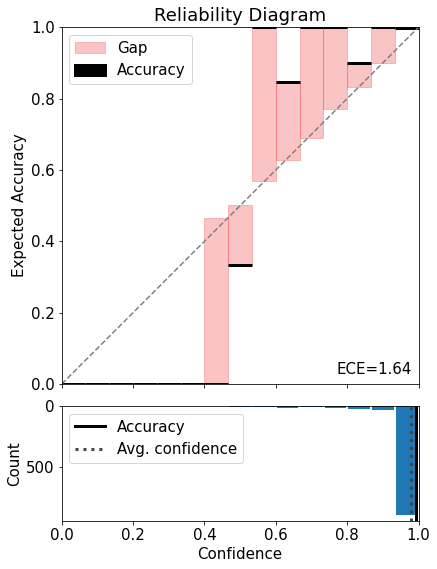

In [136]:
plt.rcParams.update({'font.size': 15})
reliability_diagram(true, predicted_classes_orig, confidence_orig, num_bins=num_bins,
                    )

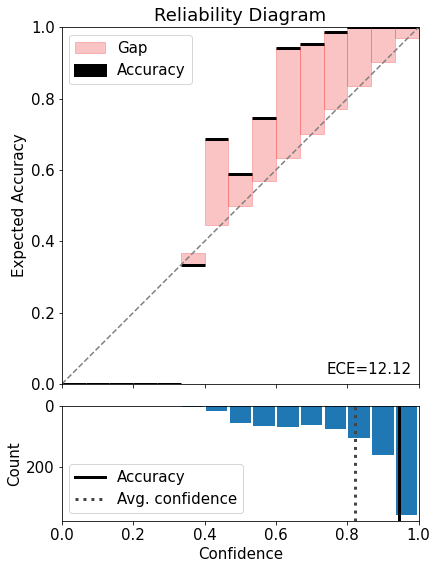

In [137]:
reliability_diagram(true, predicted_classes_mc, confidence_mc, num_bins=num_bins)

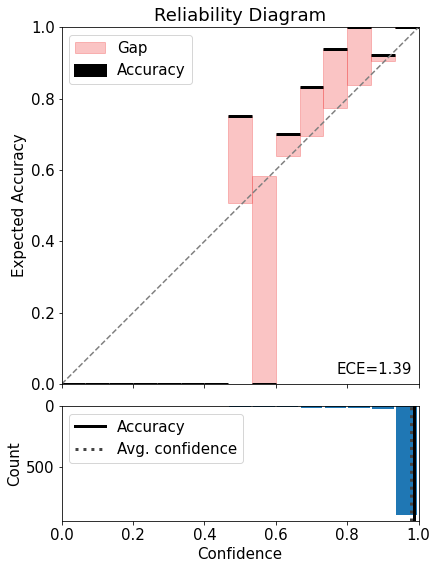

In [138]:
reliability_diagram(true, predicted_classes_alea, confidence_alea, num_bins=num_bins)

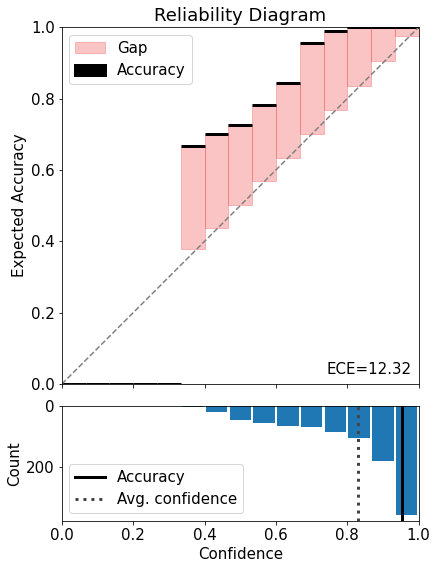

In [139]:
reliability_diagram(true, predicted_classes_total, confidence_total, num_bins=num_bins)

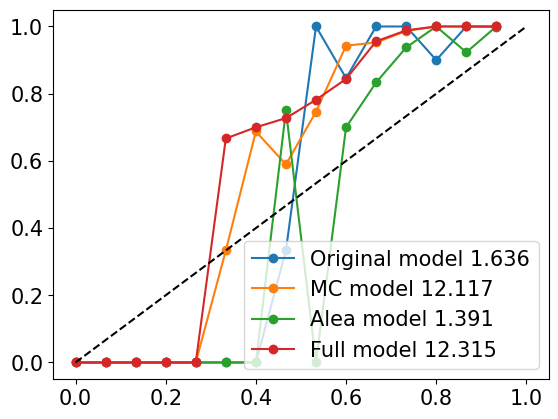

In [140]:
plt.plot(res_orig["bins"][:-1], res_orig["accuracies"], marker='o',
         label="Original model " + str(round(res_orig["expected_calibration_error"]*100,3)))
plt.plot(res_mc["bins"][:-1], res_mc["accuracies"], marker='o',
         label="MC model " + str(round(res_mc["expected_calibration_error"]*100,3)))
plt.plot(res_alea["bins"][:-1], res_alea["accuracies"], marker='o',
         label="Alea model " + str(round(res_alea["expected_calibration_error"]*100,3)))
plt.plot(res_total["bins"][:-1], res_total["accuracies"], marker='o',
         label="Full model " + str(round(res_total["expected_calibration_error"]*100,3)))
plt.plot([0,1], [0, 1], linestyle='--', color='black')
plt.legend()
plt.show()

In [141]:
from sklearn.metrics import mean_squared_error
m1 = mean_squared_error(true, predicted_classes_orig)
m2 = mean_squared_error(true, predicted_classes_mc)
m3 = mean_squared_error(true, predicted_classes_alea)
m4 = mean_squared_error(true, predicted_classes_total)

print(f"{m1:.3}, {m2:.3}, {m3:.3}, {m4:.3}")

0.00816, 0.0837, 0.0163, 0.0643


In [142]:
table4 = pd.DataFrame(dict(Wine=['Baseline', '+ Epistemic Uncertainty',
                                 '+ Aleatoric Uncertainty', 
                                 '+ Epistemic & Aleatoric'],
                  ECE=[round(res_orig["expected_calibration_error"]*100,3),
                       round(res_mc["expected_calibration_error"]*100,3),
                       round(res_alea["expected_calibration_error"]*100,3),
                       round(res_total["expected_calibration_error"]*100,3)],
                  MSE=[round(m1,3),round(m2,3),round(m3,3),round(m4,3)]))
                  
print(table4.to_latex(index=False)) 

\begin{tabular}{lrr}
\toprule
                    Wine &     ECE &    MSE \\
\midrule
                Baseline &   1.636 &  0.008 \\
 + Epistemic Uncertainty &  12.117 &  0.084 \\
 + Aleatoric Uncertainty &   1.391 &  0.016 \\
 + Epistemic \& Aleatoric &  12.315 &  0.064 \\
\bottomrule
\end{tabular}



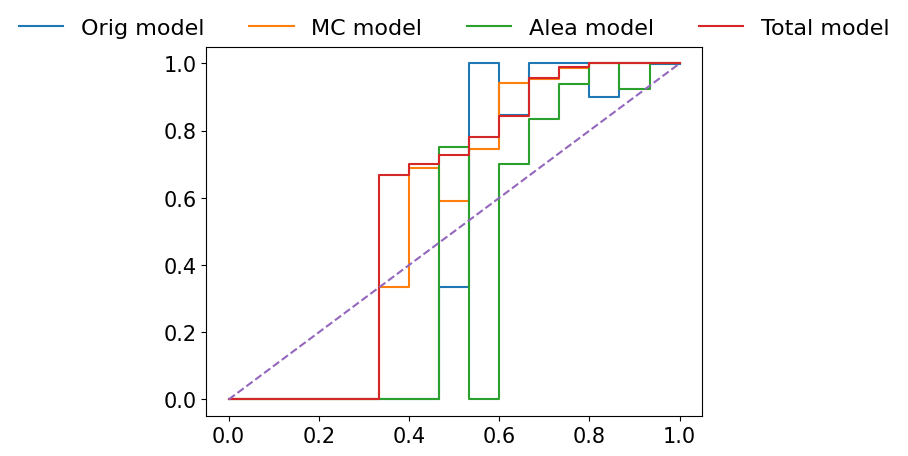

In [143]:
betterstep_new(res_orig["bins"], res_orig["accuracies"],
           res_mc["accuracies"], res_alea["accuracies"],
           res_total["accuracies"])

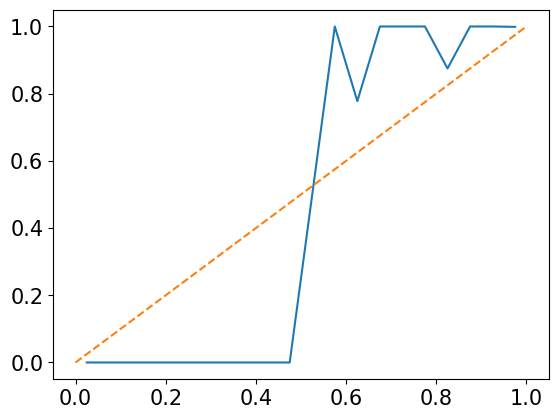

In [144]:
num_classes = 3
#create bins
binsize = 0.05
bins = np.arange(0,1+binsize,binsize)
freq = []
output = orig_mnist_model_cnn.predict(X_wine_test)
#output = tf.convert_to_tensor(orig_mnist_model_cnn.predict(X_wine_test))
#output = tf.convert_to_tensor(mc_model.predict(X_wine_test))
#predicted_classes = np.argmax(output[:,:3], axis=-1)
for i in range(bins.shape[0]-1):
  counter1 = 0
  counter2 = 0
  for probs, target in zip(output, y_wine_test_type_original-1): 
    label_pred = np.argmax(probs)
    label_nonpred = np.delete(np.arange(0, num_classes), label_pred)
    # checking highest prob
    if bins[i] <= probs[label_pred] <= bins[i+1]:
        counter1 = counter1 + 1
    if (bins[i] <= probs[label_pred] <= bins[i+1]) and (label_pred==target):
      counter2 = counter2 + 1
    # checking lower probs
    #for j in label_nonpred:
     #   if bins[i] <= probs[j] <= bins[i+1]:
      #    counter1 = counter1 + 1
       # if (bins[i] <= probs[j] <= bins[i+1]) and (j!=target):
        #  counter2 = counter2 + 1
  if counter1 == 0:
    freq.append(0)
  else:
    freq.append(counter2/counter1)

# plot bins vs frequency
plot_bins = np.arange(binsize/2, 1+binsize/2, binsize)
plt.plot(plot_bins, freq)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [147]:
#!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/Copy of WINE.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/Copy of WINE.ipynb to PDF
[NbConvertApp] Support files will be in Copy of WINE_files/
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Making directory ./Copy of WINE_files
[NbConvertApp] Maki

# Appendix: Hyperparameter tuning

In [145]:
"""# [64, 64] layers, 128 batch_size, 0.001 learning_rate

n_hiddens = [[64], [64,64], [32,32], [32,64,32]]
batch_sizes = [64, 128]
learning_rates = [0.1, 0.01, 0.001]

dropout_p = 0.0
num_classes = 3
epochs = 20
input_shape = (11)

for i, (n_hidden, batch_size, learning_rate) in enumerate(product(n_hiddens, batch_sizes, learning_rates)):
  print(f"{n_hidden} layers, {batch_size} batch_size, {learning_rate} learning_rate")

  model_orig = get_model(act="relu", dropout_prob=0.0, 
                          n_hidden=n_hidden,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
  
  history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_val, y_wine_val_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)
  
  loss_accuracy_plot(history_model_orig)
  
  save_model(model=model_orig, batch_size=batch_size, 
             n_epochs=epochs, descr="hyptune_winemodel_learningrate" + str(learning_rate*1000), 
             n_hidden=n_hidden, dropout=None)
  print(f"done with {i}th training loop\n")
"""

'# [64, 64] layers, 128 batch_size, 0.001 learning_rate\n\nn_hiddens = [[64], [64,64], [32,32], [32,64,32]]\nbatch_sizes = [64, 128]\nlearning_rates = [0.1, 0.01, 0.001]\n\ndropout_p = 0.0\nnum_classes = 3\nepochs = 20\ninput_shape = (11)\n\nfor i, (n_hidden, batch_size, learning_rate) in enumerate(product(n_hiddens, batch_sizes, learning_rates)):\n  print(f"{n_hidden} layers, {batch_size} batch_size, {learning_rate} learning_rate")\n\n  model_orig = get_model(act="relu", dropout_prob=0.0, \n                          n_hidden=n_hidden,\n                          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))\n  \n  history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, \n                       validation_data=(X_wine_val, y_wine_val_type), \n                       batch_size=batch_size, epochs=epochs, verbose=1)\n  \n  loss_accuracy_plot(history_model_orig)\n  \n  save_model(model=model_orig, batch_size=batch_size, \n             n_epochs=epochs, descr="

In [146]:
"""# tune for dropout probability
dropout_ps = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
num_classes = 3
epochs = 20
input_shape = (11)

for i, (dropout_p) in enumerate(dropout_ps):
  print(f"{dropout_p} dropout_p")
  model_orig = get_model(act="relu", dropout_prob=dropout_p, 
                          n_hidden=[64,64],
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
  
  history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_val, y_wine_val_type), 
                       batch_size=128, epochs=epochs, verbose=1)
  
  loss_accuracy_plot(history_model_orig)
  
  save_model(model=model_orig, batch_size=128, 
             n_epochs=epochs, descr="hyptunedropout_winemodel_learningrate" + str(0.001*1000), 
             n_hidden=[64,64], dropout=dropout_p)
  print(f"done with {i}th training loop\n")"""

'# tune for dropout probability\ndropout_ps = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]\nnum_classes = 3\nepochs = 20\ninput_shape = (11)\n\nfor i, (dropout_p) in enumerate(dropout_ps):\n  print(f"{dropout_p} dropout_p")\n  model_orig = get_model(act="relu", dropout_prob=dropout_p, \n                          n_hidden=[64,64],\n                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))\n  \n  history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, \n                       validation_data=(X_wine_val, y_wine_val_type), \n                       batch_size=128, epochs=epochs, verbose=1)\n  \n  loss_accuracy_plot(history_model_orig)\n  \n  save_model(model=model_orig, batch_size=128, \n             n_epochs=epochs, descr="hyptunedropout_winemodel_learningrate" + str(0.001*1000), \n             n_hidden=[64,64], dropout=dropout_p)\n  print(f"done with {i}th training loop\n")'